Importing necessary libraries.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
from IPython.display import display

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
import scipy.stats as stats

# Scikit-learn Modules
from sklearn.preprocessing import (
    LabelEncoder, RobustScaler, StandardScaler
)
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, learning_curve, StratifiedKFold
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    recall_score, f1_score, roc_auc_score, brier_score_loss,
    fbeta_score, roc_curve, precision_recall_curve, classification_report
)

# Imbalanced-learn Modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# SHAP for Explainability
import shap


Importing the dataset, cleaning null values, changing the date-time format for proper handling, dropping the original date-time to prevent data leakage to the model, setting an index to maintain explainability, and extracting date-time components for handling cyclic patterns in the next steps.

In [ ]:


def load_and_clean_data() -> Tuple[pd.DataFrame, pd.DataFrame]:

    url = 'https://raw.githubusercontent.com/mtech00/EPAM_DS/refs/heads/main/test2/AirQualityUCI.csv'
    df_original = pd.read_csv(url, delimiter=';', decimal=',')

    df_cleaned = df_original.copy()

    df_cleaned['Time'] = df_cleaned['Time'].str.replace('.', ':')
    df_cleaned['DateTime'] = pd.to_datetime(
        df_cleaned['Date'] + ' ' + df_cleaned['Time'],
        format='%d/%m/%Y %H:%M:%S'
    )

    columns_to_drop = ['Date', 'Time']
    df_cleaned = df_cleaned.drop(columns_to_drop, axis=1)
    df_cleaned = df_cleaned.dropna(axis=1, how='all')


    df_cleaned['year'] = df_cleaned['DateTime'].dt.year
    df_cleaned['month'] = df_cleaned['DateTime'].dt.month
    df_cleaned['day'] = df_cleaned['DateTime'].dt.day
    df_cleaned['hour'] = df_cleaned['DateTime'].dt.hour

    df_cleaned.set_index('DateTime', inplace=True)
    df_cleaned = df_cleaned.replace(-200, np.nan)


    print("Original data shape:", df_original.shape)
    print("Cleaned data shape:", df_cleaned.shape)
    print("Cleaned columns:", list(df_cleaned.columns))







---

## Air Quality Dataset

### Main Link
[Air Quality Dataset on UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality#)

### Data Set Information
The dataset contains **9,358 instances** of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was deployed in a **significantly polluted area at road level within an Italian city**. Data were collected from **March 2004 to February 2005** (one year), representing the longest freely available recordings of on-field deployed air quality chemical sensor device responses.

The dataset includes:

- **Ground Truth** hourly averaged concentrations for:
  - **CO** (Carbon Monoxide),
  - **Non-Methanic Hydrocarbons (NMHC)**,
  - **Benzene**,
  - **Total Nitrogen Oxides (NOx)**, and
  - **Nitrogen Dioxide (NO₂)**.

These values were provided by a **co-located reference certified analyzer**. The dataset shows evidence of **cross-sensitivities, sensor drift, and concept drift** (De Vito et al., *Sensors and Actuators B*, Vol. 129, 2, 2008), affecting sensor estimation capabilities.

**Missing values** are tagged with **-200**.

> **Note:** This dataset is for **research purposes only**. Commercial use is prohibited.

### Attribute Information

| Index | Attribute Description                                                                                      |
|-------|------------------------------------------------------------------------------------------------------------|
| **0** | Date (DD/MM/YYYY)                                                                                         |
| **1** | Time (HH.MM.SS)                                                                                           |
| **2** | True hourly averaged concentration of CO in mg/m³ (reference analyzer)                                    |
| **3** | PT08.S1 (Tin oxide) hourly averaged sensor response (nominally CO targeted)                               |
| **4** | True hourly averaged Non-Methanic Hydrocarbons concentration in µg/m³ (reference analyzer)                |
| **5** | True hourly averaged Benzene concentration in µg/m³ (reference analyzer)                                  |
| **6** | PT08.S2 (Titania) hourly averaged sensor response (nominally NMHC targeted)                               |
| **7** | True hourly averaged NOx concentration in ppb (reference analyzer)                                        |
| **8** | PT08.S3 (Tungsten oxide) hourly averaged sensor response (nominally NOx targeted)                         |
| **9** | True hourly averaged NO₂ concentration in µg/m³ (reference analyzer)                                      |
| **10**| PT08.S4 (Tungsten oxide) hourly averaged sensor response (nominally NO₂ targeted)                         |
| **11**| PT08.S5 (Indium oxide) hourly averaged sensor response (nominally O₃ targeted)                            |
| **12**| Temperature in °C                                                                                         |
| **13**| Relative Humidity (%)                                                                                     |
| **14**| Absolute Humidity                                                                                         |



Getting basic information such as shape, column names, etc.

In [ ]:
df_cleaned, df_original = load_and_clean_data()

Original data shape: (9471, 17)
Cleaned data shape: (9471, 17)
Cleaned columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'year', 'month', 'day', 'hour']


In [ ]:
df_cleaned.shape

(9471, 17)

In [ ]:
df_cleaned.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [ ]:
df_cleaned.head(5).T

DateTime       2004-03-10 18:00:00  2004-03-10 19:00:00  2004-03-10 20:00:00  \
CO(GT)                      2.6000               2.0000               2.2000   
PT08.S1(CO)              1360.0000            1292.0000            1402.0000   
NMHC(GT)                  150.0000             112.0000              88.0000   
C6H6(GT)                   11.9000               9.4000               9.0000   
PT08.S2(NMHC)            1046.0000             955.0000             939.0000   
NOx(GT)                   166.0000             103.0000             131.0000   
PT08.S3(NOx)             1056.0000            1174.0000            1140.0000   
NO2(GT)                   113.0000              92.0000             114.0000   
PT08.S4(NO2)             1692.0000            1559.0000            1555.0000   
PT08.S5(O3)              1268.0000             972.0000            1074.0000   
T                          13.6000              13.3000              11.9000   
RH                         48.9000              47.7000              54.0000   
AH                          0.7578               0.7255               0.7502   
year                     2004.0000            2004.0000            2004.0000   
month                       3.0000               3.0000               3.0000   
day                        10.0000              10.0000              10.0000   
hour                       18.0000              19.0000              20.0000   

DateTime       2004-03-10 21:00:00  2004-03-10 22:00:00  
CO(GT)                      2.2000               1.6000  
PT08.S1(CO)              1376.0000            1272.0000  
NMHC(GT)                   80.0000              51.0000  
C6H6(GT)                    9.2000               6.5000  
PT08.S2(NMHC)             948.0000             836.0000  
NOx(GT)                   172.0000             131.0000  
PT08.S3(NOx)             1092.0000            1205.0000  
NO2(GT)                   122.0000             116.0000  
PT08.S4(NO2)             1584.0000            1490.0000  
PT08.S5(O3)              1203.0000            1110.0000  
T                          11.0000              11.2000  
RH                         60.0000              59.6000  
AH                          0.7867               0.7888  
year                     2004.0000            2004.0000  
month                       3.0000               3.0000  
day                        10.0000              10.0000  
hour                       21.0000              22.0000

Getting statistical information; there are near-zero or negative values.

In [ ]:
df_cleaned.describe().T

count         mean         std        min        25%  \
CO(GT)         7674.0     2.152750    1.453252     0.1000     1.1000   
PT08.S1(CO)    8991.0  1099.833166  217.080037   647.0000   937.0000   
NMHC(GT)        914.0   218.811816  204.459921     7.0000    67.0000   
C6H6(GT)       8991.0    10.083105    7.449820     0.1000     4.4000   
PT08.S2(NMHC)  8991.0   939.153376  266.831429   383.0000   734.5000   
NOx(GT)        7718.0   246.896735  212.979168     2.0000    98.0000   
PT08.S3(NOx)   8991.0   835.493605  256.817320   322.0000   658.0000   
NO2(GT)        7715.0   113.091251   48.370108     2.0000    78.0000   
PT08.S4(NO2)   8991.0  1456.264598  346.206794   551.0000  1227.0000   
PT08.S5(O3)    8991.0  1022.906128  398.484288   221.0000   731.5000   
T              8991.0    18.317829    8.832116    -1.9000    11.8000   
RH             8991.0    49.234201   17.316892     9.2000    35.8000   
AH             8991.0     1.025530    0.403813     0.1847     0.7368   
year           9357.0  2004.240141    0.427192  2004.0000  2004.0000   
month          9357.0     6.310356    3.438160     1.0000     3.0000   
day            9357.0    15.876884    8.808653     1.0000     8.0000   
hour           9357.0    11.498557    6.923182     0.0000     5.0000   

                     50%        75%       max  
CO(GT)            1.8000     2.9000    11.900  
PT08.S1(CO)    1063.0000  1231.0000  2040.000  
NMHC(GT)        150.0000   297.0000  1189.000  
C6H6(GT)          8.2000    14.0000    63.700  
PT08.S2(NMHC)   909.0000  1116.0000  2214.000  
NOx(GT)         180.0000   326.0000  1479.000  
PT08.S3(NOx)    806.0000   969.5000  2683.000  
NO2(GT)         109.0000   142.0000   340.000  
PT08.S4(NO2)   1463.0000  1674.0000  2775.000  
PT08.S5(O3)     963.0000  1273.5000  2523.000  
T                17.8000    24.4000    44.600  
RH               49.6000    62.5000    88.700  
AH                0.9954     1.3137     2.231  
year           2004.0000  2004.0000  2005.000  
month             6.0000     9.0000    12.000  
day              16.0000    23.0000    31.000  
hour             11.0000    18.0000    23.000

All values are of ordinal number type.

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9471 entries, 2004-03-10 18:00:00 to NaT
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7674 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       914 non-null    float64
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        7718 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        7715 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
 13  year           9357 non-null   float64
 14  month          9357 non-null   float64
 15  day            9357 non-null   float64
 16  hour           9357 non-null   float64
dtypes: float64(17)
memory usage: 1.3

In [ ]:
Even though the values are ordinal, some are still explainable within a limited set of classes.

SyntaxError: invalid syntax (<ipython-input-1-2bc7ac2906ad>, line 1)

In [ ]:
df_cleaned.nunique()

CO(GT)             96
PT08.S1(CO)      1041
NMHC(GT)          429
C6H6(GT)          407
PT08.S2(NMHC)    1245
NOx(GT)           925
PT08.S3(NOx)     1221
NO2(GT)           283
PT08.S4(NO2)     1603
PT08.S5(O3)      1743
T                 436
RH                753
AH               6683
year                2
month              12
day                31
hour               24
dtype: int64

Now handling null values: Forward fill is a good approach for time series data to maintain continuity. If a significant portion of a column is missing, dropping the column is more appropriate since handling it effectively isn't possible. The data consists mainly of sensor readings, which naturally contain many outliers due to the nature of electrical sensors. Considering this, using the median to handle null values is preferable. Additionally, adding cyclic features (e.g., day and hour) is beneficial because the model cannot interpret transitions like day 30 to day 1 or hour 23 to hour 0. Cyclic features will improve the interpretability of these patterns.

In [ ]:


def prepare_data(df, add_cyclic_features=False):

    if isinstance(df.index, pd.DatetimeIndex):
        df.index = df.index.to_series().fillna(method='ffill')
        print("Forward-filled missing DateTime values.")


    print("\nPercentage of null values per column:")
    null_percentages = (df.isnull().mean() * 100).sort_values(ascending=False)
    print(null_percentages)

    columns_to_drop = null_percentages[null_percentages > 50].index
    df = df.drop(columns=columns_to_drop)
    print(f"\nDropped columns with more than 50% missing values: {list(columns_to_drop)}")

    df.fillna(df.median(), inplace=True)

    if isinstance(df.index, pd.DatetimeIndex):
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['day'] = df.index.day
        df['hour'] = df.index.hour

        if add_cyclic_features:
            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
            df.drop(['month', 'hour',], axis=1, inplace=True)

    print(f"\nFinal shape: {df.shape}")
    return df


In [ ]:
df_prepared = prepare_data(df_cleaned, add_cyclic_features=True)

Forward-filled missing DateTime values.

Percentage of null values per column:
NMHC(GT)         90.349488
CO(GT)           18.973709
NO2(GT)          18.540809
NOx(GT)          18.509133
PT08.S1(CO)       5.068103
PT08.S2(NMHC)     5.068103
C6H6(GT)          5.068103
PT08.S3(NOx)      5.068103
PT08.S4(NO2)      5.068103
PT08.S5(O3)       5.068103
T                 5.068103
RH                5.068103
AH                5.068103
year              1.203674
month             1.203674
day               1.203674
hour              1.203674
dtype: float64

Dropped columns with more than 50% missing values: ['NMHC(GT)']

Final shape: (9471, 18)


In [ ]:
df_prepared

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
DateTime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   
...                     ...          ...       ...            ...      ...   
2005-04-04 14:00:00     1.8       1063.0       8.2          909.0    180.0   
2005-04-04 14:00:00     1.8       1063.0       8.2          909.0    180.0   
2005-04-04 14:00:00     1.8       1063.0       8.2          909.0    180.0   
2005-04-04 14:00:00     1.8       1063.0       8.2          909.0    180.0   
2005-04-04 14:00:00     1.8       1063.0       8.2          909.0    180.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
DateTime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1555.0       1074.0  11.9   
2004-03-10 21:00:00        1092.0    122.0        1584.0       1203.0  11.0   
2004-03-10 22:00:00        1205.0    116.0        1490.0       1110.0  11.2   
...                           ...      ...           ...          ...   ...   
2005-04-04 14:00:00         806.0    109.0        1463.0        963.0  17.8   
2005-04-04 14:00:00         806.0    109.0        1463.0        963.0  17.8   
2005-04-04 14:00:00         806.0    109.0        1463.0        963.0  17.8   
2005-04-04 14:00:00         806.0    109.0        1463.0        963.0  17.8   
2005-04-04 14:00:00         806.0    109.0        1463.0        963.0  17.8   

                       RH      AH  year  day  month_sin     month_cos  \
DateTime                                                                
2004-03-10 18:00:00  48.9  0.7578  2004   10   1.000000  6.123234e-17   
2004-03-10 19:00:00  47.7  0.7255  2004   10   1.000000  6.123234e-17   
2004-03-10 20:00:00  54.0  0.7502  2004   10   1.000000  6.123234e-17   
2004-03-10 21:00:00  60.0  0.7867  2004   10   1.000000  6.123234e-17   
2004-03-10 22:00:00  59.6  0.7888  2004   10   1.000000  6.123234e-17   
...                   ...     ...   ...  ...        ...           ...   
2005-04-04 14:00:00  49.6  0.9954  2005    4   0.866025 -5.000000e-01   
2005-04-04 14:00:00  49.6  0.9954  2005    4   0.866025 -5.000000e-01   
2005-04-04 14:00:00  49.6  0.9954  2005    4   0.866025 -5.000000e-01   
2005-04-04 14:00:00  49.6  0.9954  2005    4   0.866025 -5.000000e-01   
2005-04-04 14:00:00  49.6  0.9954  2005    4   0.866025 -5.000000e-01   

                     hour_sin      hour_cos  
DateTime                                     
2004-03-10 18:00:00 -1.000000 -1.836970e-16  
2004-03-10 19:00:00 -0.965926  2.588190e-01  
2004-03-10 20:00:00 -0.866025  5.000000e-01  
2004-03-10 21:00:00 -0.707107  7.071068e-01  
2004-03-10 22:00:00 -0.500000  8.660254e-01  
...                       ...           ...  
2005-04-04 14:00:00 -0.500000 -8.660254e-01  
2005-04-04 14:00:00 -0.500000 -8.660254e-01  
2005-04-04 14:00:00 -0.500000 -8.660254e-01  
2005-04-04 14:00:00 -0.500000 -8.660254e-01  
2005-04-04 14:00:00 -0.500000 -8.660254e-01  

[9471 rows x 18 columns]

In [ ]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9471 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9471 non-null   float64
 1   PT08.S1(CO)    9471 non-null   float64
 2   C6H6(GT)       9471 non-null   float64
 3   PT08.S2(NMHC)  9471 non-null   float64
 4   NOx(GT)        9471 non-null   float64
 5   PT08.S3(NOx)   9471 non-null   float64
 6   NO2(GT)        9471 non-null   float64
 7   PT08.S4(NO2)   9471 non-null   float64
 8   PT08.S5(O3)    9471 non-null   float64
 9   T              9471 non-null   float64
 10  RH             9471 non-null   float64
 11  AH             9471 non-null   float64
 12  year           9471 non-null   int32  
 13  day            9471 non-null   int32  
 14  month_sin      9471 non-null   float64
 15  month_cos      9471 non-null   float64
 16  hour_sin       9471 non-null   float64
 17  hour_cos       9

In [ ]:
df_prepared.describe().T

count         mean         std        min          25%  \
CO(GT)         9471.0     2.085820    1.315415     0.1000     1.200000   
PT08.S1(CO)    9471.0  1097.966424  211.661265   647.0000   943.000000   
C6H6(GT)       9471.0     9.987668    7.270307     0.1000     4.600000   
PT08.S2(NMHC)  9471.0   937.625172  260.065263   383.0000   744.000000   
NOx(GT)        9471.0   234.514729  194.006563     2.0000   113.000000   
PT08.S3(NOx)   9471.0   833.998839  250.307741   322.0000   667.000000   
NO2(GT)        9471.0   112.332700   43.684741     2.0000    86.000000   
PT08.S4(NO2)   9471.0  1456.605955  337.321954   551.0000  1246.000000   
PT08.S5(O3)    9471.0  1019.870024  388.476425   221.0000   744.500000   
T              9471.0    18.291585    8.606121    -1.9000    12.100000   
RH             9471.0    49.252740   16.872511     9.2000    36.700000   
AH             9471.0     1.024003    0.393501     0.1847     0.750100   
year           9471.0  2004.249287    0.432623  2004.0000  2004.000000   
day            9471.0    15.733925    8.850760     1.0000     8.000000   
month_sin      9471.0     0.067251    0.725164    -1.0000    -0.500000   
month_cos      9471.0    -0.012806    0.685242    -1.0000    -0.500000   
hour_sin       9471.0    -0.005750    0.704938    -1.0000    -0.707107   
hour_cos       9471.0    -0.010269    0.709245    -1.0000    -0.707107   

                        50%          75%       max  
CO(GT)         1.800000e+00     2.600000    11.900  
PT08.S1(CO)    1.063000e+03  1218.000000  2040.000  
C6H6(GT)       8.200000e+00    13.500000    63.700  
PT08.S2(NMHC)  9.090000e+02  1102.000000  2214.000  
NOx(GT)        1.800000e+02   281.500000  1479.000  
PT08.S3(NOx)   8.060000e+02   957.000000  2683.000  
NO2(GT)        1.090000e+02   132.000000   340.000  
PT08.S4(NO2)   1.463000e+03  1658.000000  2775.000  
PT08.S5(O3)    9.630000e+02  1250.000000  2523.000  
T              1.780000e+01    24.000000    44.600  
RH             4.960000e+01    61.700000    88.700  
AH             9.954000e-01     1.291500     2.231  
year           2.004000e+03  2004.000000  2005.000  
day            1.600000e+01    23.000000    31.000  
month_sin      1.224647e-16     0.866025     1.000  
month_cos      6.123234e-17     0.500000     1.000  
hour_sin       0.000000e+00     0.707107     1.000  
hour_cos      -1.836970e-16     0.707107     1.000

Now, we will create a simple baseline model for comparison.

In [ ]:


def simple_linear_model(df, target_col, test_size=0.2, random_state=42):

    X = df.drop(columns=target_col)
    y = df[target_col]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


    model = LinearRegression().fit(X_train, y_train)


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    baseline_metrics = [
        {
            'Dataset': 'Train',
            'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'R2': r2_score(y_train, y_train_pred)
        },
        {
            'Dataset': 'Test',
            'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'MAE': mean_absolute_error(y_test, y_test_pred),
            'R2': r2_score(y_test, y_test_pred)
        }
    ]

    print("\nModel Performance:")
    for metric in baseline_metrics:
        print(f"{metric['Dataset']} R²: {metric['R2']:.4f}")
        print(f"{metric['Dataset']} RMSE: {metric['RMSE']:.4f}")
        print(f"{metric['Dataset']} MAE: {metric['MAE']:.4f}")


    feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
    feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)


    print(feature_importance.head())


    plt.figure(figsize=(12, 8))


    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')


    residuals = y_test - y_test_pred
    plt.subplot(2, 2, 2)
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')


    plt.subplot(2, 2, 3)
    top_features = feature_importance.head(5)
    plt.barh(top_features['Feature'], top_features['Coefficient'])
    plt.xlabel('Coefficient Value')
    plt.title('Top 5 Feature Importance')

    plt.subplot(2, 2, 4)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution')

    plt.tight_layout()
    plt.show()

    return model, baseline_metrics




Model Performance:
Train R²: 0.9816
Train RMSE: 0.9803
Train MAE: 0.6974
Test R²: 0.9775
Test RMSE: 1.1183
Test MAE: 0.7254

Top 5 Most Important Features:
      Feature  Coefficient
11       year     2.013638
13  month_sin    -1.047384
10         AH    -0.416045
15   hour_sin     0.408881
0      CO(GT)     0.300178


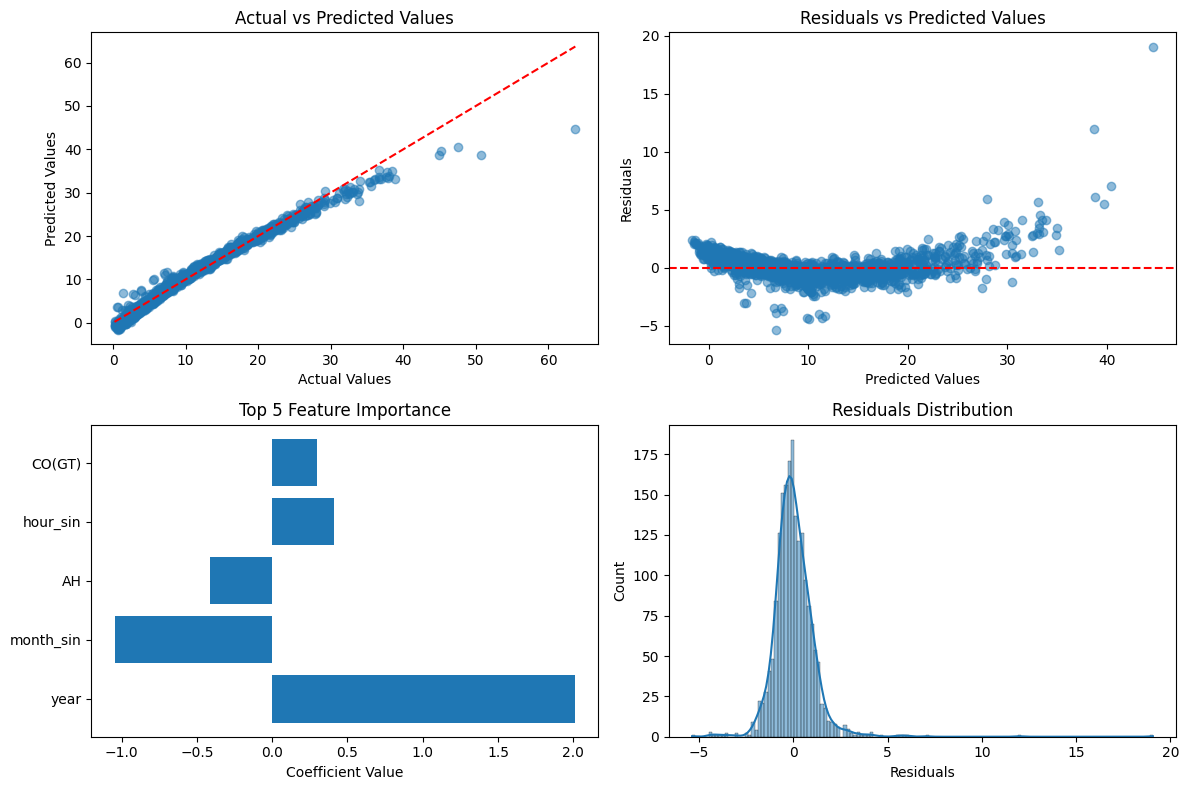

In [ ]:
model, baseline_metrics = simple_linear_model(df_prepared, target_col='C6H6(GT)')

min_samples_leaf importmant hyperparameter for regression

In [ ]:


def analyze_decision_tree(df_prepared, target_col='C6H6(GT)', test_size=0.2, random_state=42):


    df_prepared = df_prepared.dropna(subset=[target_col])
    X = df_prepared.drop(columns=[target_col])
    y = df_prepared[target_col]
    feature_names = X.columns.tolist()


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )


    print("=== Initial Model Performance ===")
    initial_model = DecisionTreeRegressor(random_state=random_state)
    initial_model.fit(X_train, y_train)

    y_pred_initial = initial_model.predict(X_test)
    initial_rmse = np.sqrt(mean_squared_error(y_test, y_pred_initial))
    initial_r2 = r2_score(y_test, y_pred_initial)

    print(f"Initial RMSE: {initial_rmse:.4f}")
    print(f"Initial R²: {initial_r2:.4f}")


    print("\n=== Hyperparameter Tuning ===")
    param_grid = {
        'max_depth': [3, 5, 7, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }

    grid_search = GridSearchCV(
        DecisionTreeRegressor(random_state=random_state),
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)


    print("\nBest Parameters:", grid_search.best_params_)
    print(f"Best Cross-Validation RMSE: {-grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)
    best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
    best_r2 = r2_score(y_test, y_pred_best)

    print(f"\nFinal Model Performance:")
    print(f"Best Model RMSE: {best_rmse:.4f}")
    print(f"Best Model R²: {best_r2:.4f}")


    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 5 Most Important Features:")
    print(feature_importance.head())


    plt.figure(figsize=(12, 30))


    plt.subplot(6, 1, 1)
    plt.scatter(y_test, y_pred_best, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values (Best Model)')


    plt.subplot(6, 1, 2)
    sns.barplot(data=feature_importance.head(5), x='importance', y='feature')
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Importance')


    plt.subplot(6, 1, 3)
    plot_tree(best_model, max_depth=3, feature_names=feature_names,
             filled=True, rounded=True, fontsize=8)
    plt.title('Decision Tree Structure (First 3 Levels)')


    plt.subplot(6, 1, 4)
    max_depths = param_grid['max_depth']
    cv_results = pd.DataFrame(grid_search.cv_results_)
    mean_scores = []
    for depth in max_depths:
        mask = cv_results['param_max_depth'] == depth
        mean_scores.append(-cv_results.loc[mask, 'mean_test_score'].mean())

    plt.plot(max_depths, mean_scores, marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Average RMSE')
    plt.title('Impact of Max Depth on Model Performance')

    plt.subplot(6, 1, 5)
    top_features = feature_importance['feature'].head(2).tolist()

    plt.scatter(X[top_features[0]], X[top_features[1]], c=y,
               cmap='RdYlBu', alpha=0.6)
    plt.colorbar(label='Target Value')
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.title('Decision Boundary (Top 2 Important Features)')


    plt.subplot(6, 1, 6)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)


    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/100),
                        np.arange(y_min, y_max, (y_max-y_min)/100))

    mesh_pca = np.c_[xx.ravel(), yy.ravel()]
    mesh_original = pca.inverse_transform(mesh_pca)
    mesh_original = scaler.inverse_transform(mesh_original)


    Z = best_model.predict(mesh_original)
    Z = Z.reshape(xx.shape)


    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,
                         cmap='RdYlBu', alpha=0.6)
    plt.colorbar(scatter, label='Target Value')
    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('PCA-based Decision Boundary')

    plt.tight_layout(pad=3.0)
    plt.show()

    print("\n=== PCA Analysis ===")
    print(f"Variance explained by first two components: {pca.explained_variance_ratio_.sum():.2%}")
    print("\nFeature contributions to first principal component:")
    pc1_contributions = pd.DataFrame({
        'feature': feature_names,
        'contribution': np.abs(pca.components_[0])
    }).sort_values('contribution', ascending=False)
    print(pc1_contributions.head())


    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)
    plt.figure()
    shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot (Best Model)')
    plt.show()
    decisiontree_metrics = {
        'initial_rmse': initial_rmse,
        'initial_r2': initial_r2,
        'best_rmse': best_rmse,
        'best_r2': best_r2,
        'best_cv_rmse': -grid_search.best_score_,
        'best_parameters': grid_search.best_params_,
        'pca_variance_explained': pca.explained_variance_ratio_.sum()
    }

    return best_model, feature_importance, grid_search, pca, decisiontree_metrics




Now, we will train our first model, perform hyperparameter tuning, and conduct SHAP analysis. We will visualize the effects of different features and analyze how the model's performance is impacted by changes in *max depth*, which is computationally expensive and broadly influential.  

*PT08.S1* and *PT08.S2* are the top two important features and may exhibit multicollinearity. This relationship is also reflected in the SHAP analysis, where these features noticeably increase the model's output more than other important features. In contrast, some features, such as *day*, *hour*, *cosine of the year*, etc., have nearly zero effect on the model's predictions.

=== Initial Model Performance ===
Initial RMSE: 0.2729
Initial R²: 0.9987

=== Hyperparameter Tuning ===

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation RMSE: 1.1495

Final Model Performance:
Best Model RMSE: 1.0610
Best Model R²: 0.9797

Top 5 Most Important Features:
         feature  importance
1    PT08.S1(CO)    0.639128
2  PT08.S2(NMHC)    0.126938
0         CO(GT)    0.114715
7    PT08.S5(O3)    0.032201
4   PT08.S3(NOx)    0.027955


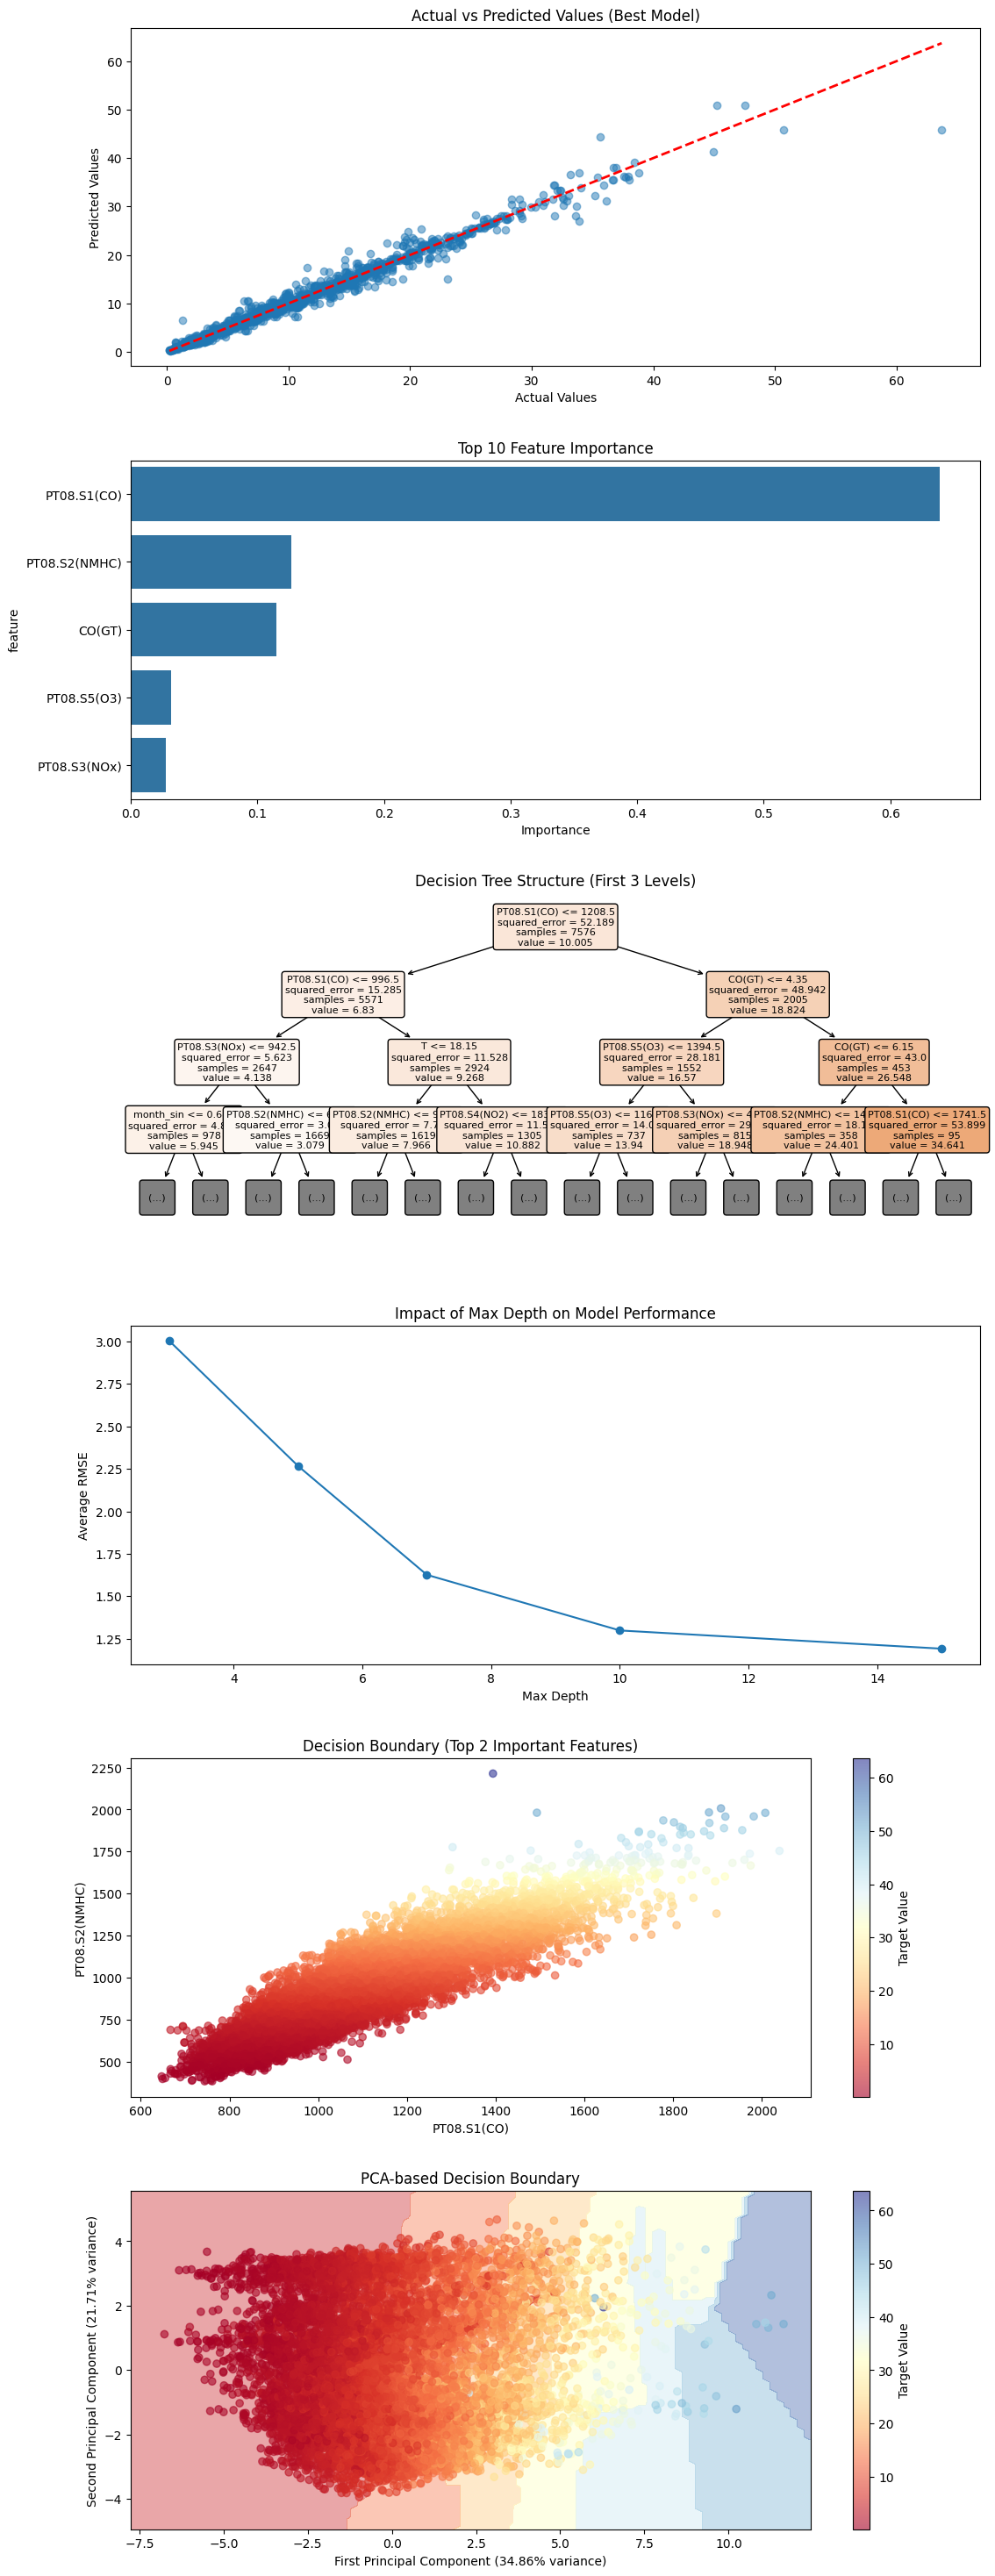


=== PCA Analysis ===
Variance explained by first two components: 56.57%

Feature contributions to first principal component:
         feature  contribution
2  PT08.S2(NMHC)      0.389485
1    PT08.S1(CO)      0.380007
7    PT08.S5(O3)      0.378287
0         CO(GT)      0.361181
4   PT08.S3(NOx)      0.350164


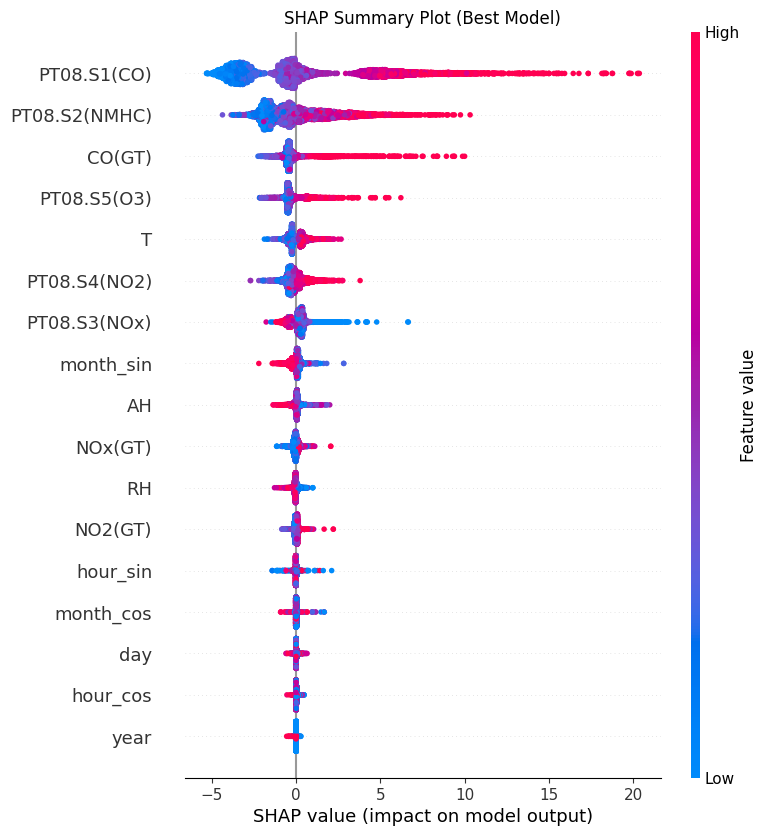

In [ ]:
best_model, feature_importance, grid_search, pca ,decisiontree_metrics  = analyze_decision_tree(df_prepared)

In [ ]:
decisiontree_metrics

{'initial_rmse': np.float64(0.27292029628931797),
 'initial_r2': np.float64(0.9986578433764054),
 'best_rmse': np.float64(1.0609560754563865),
 'best_r2': np.float64(0.9797172732906752),
 'best_cv_rmse': np.float64(1.1494884165069774),
 'best_parameters': {'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5},
 'pca_variance_explained': np.float64(0.5657139065985792)}

Here, I attempted to import the data without handling the null values.

=== Initial Model Performance ===
Initial RMSE: 0.1009
Initial R²: 0.9998

=== Hyperparameter Tuning ===

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation RMSE: 1.1767

Final Model Performance:
Best Model RMSE: 0.9867
Best Model R²: 0.9831

Top 5 Most Important Features:
         feature  importance
8    PT08.S5(O3)    0.600033
3  PT08.S2(NMHC)    0.225556
7   PT08.S4(NO2)    0.105222
5   PT08.S3(NOx)    0.022823
0         CO(GT)    0.017262


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

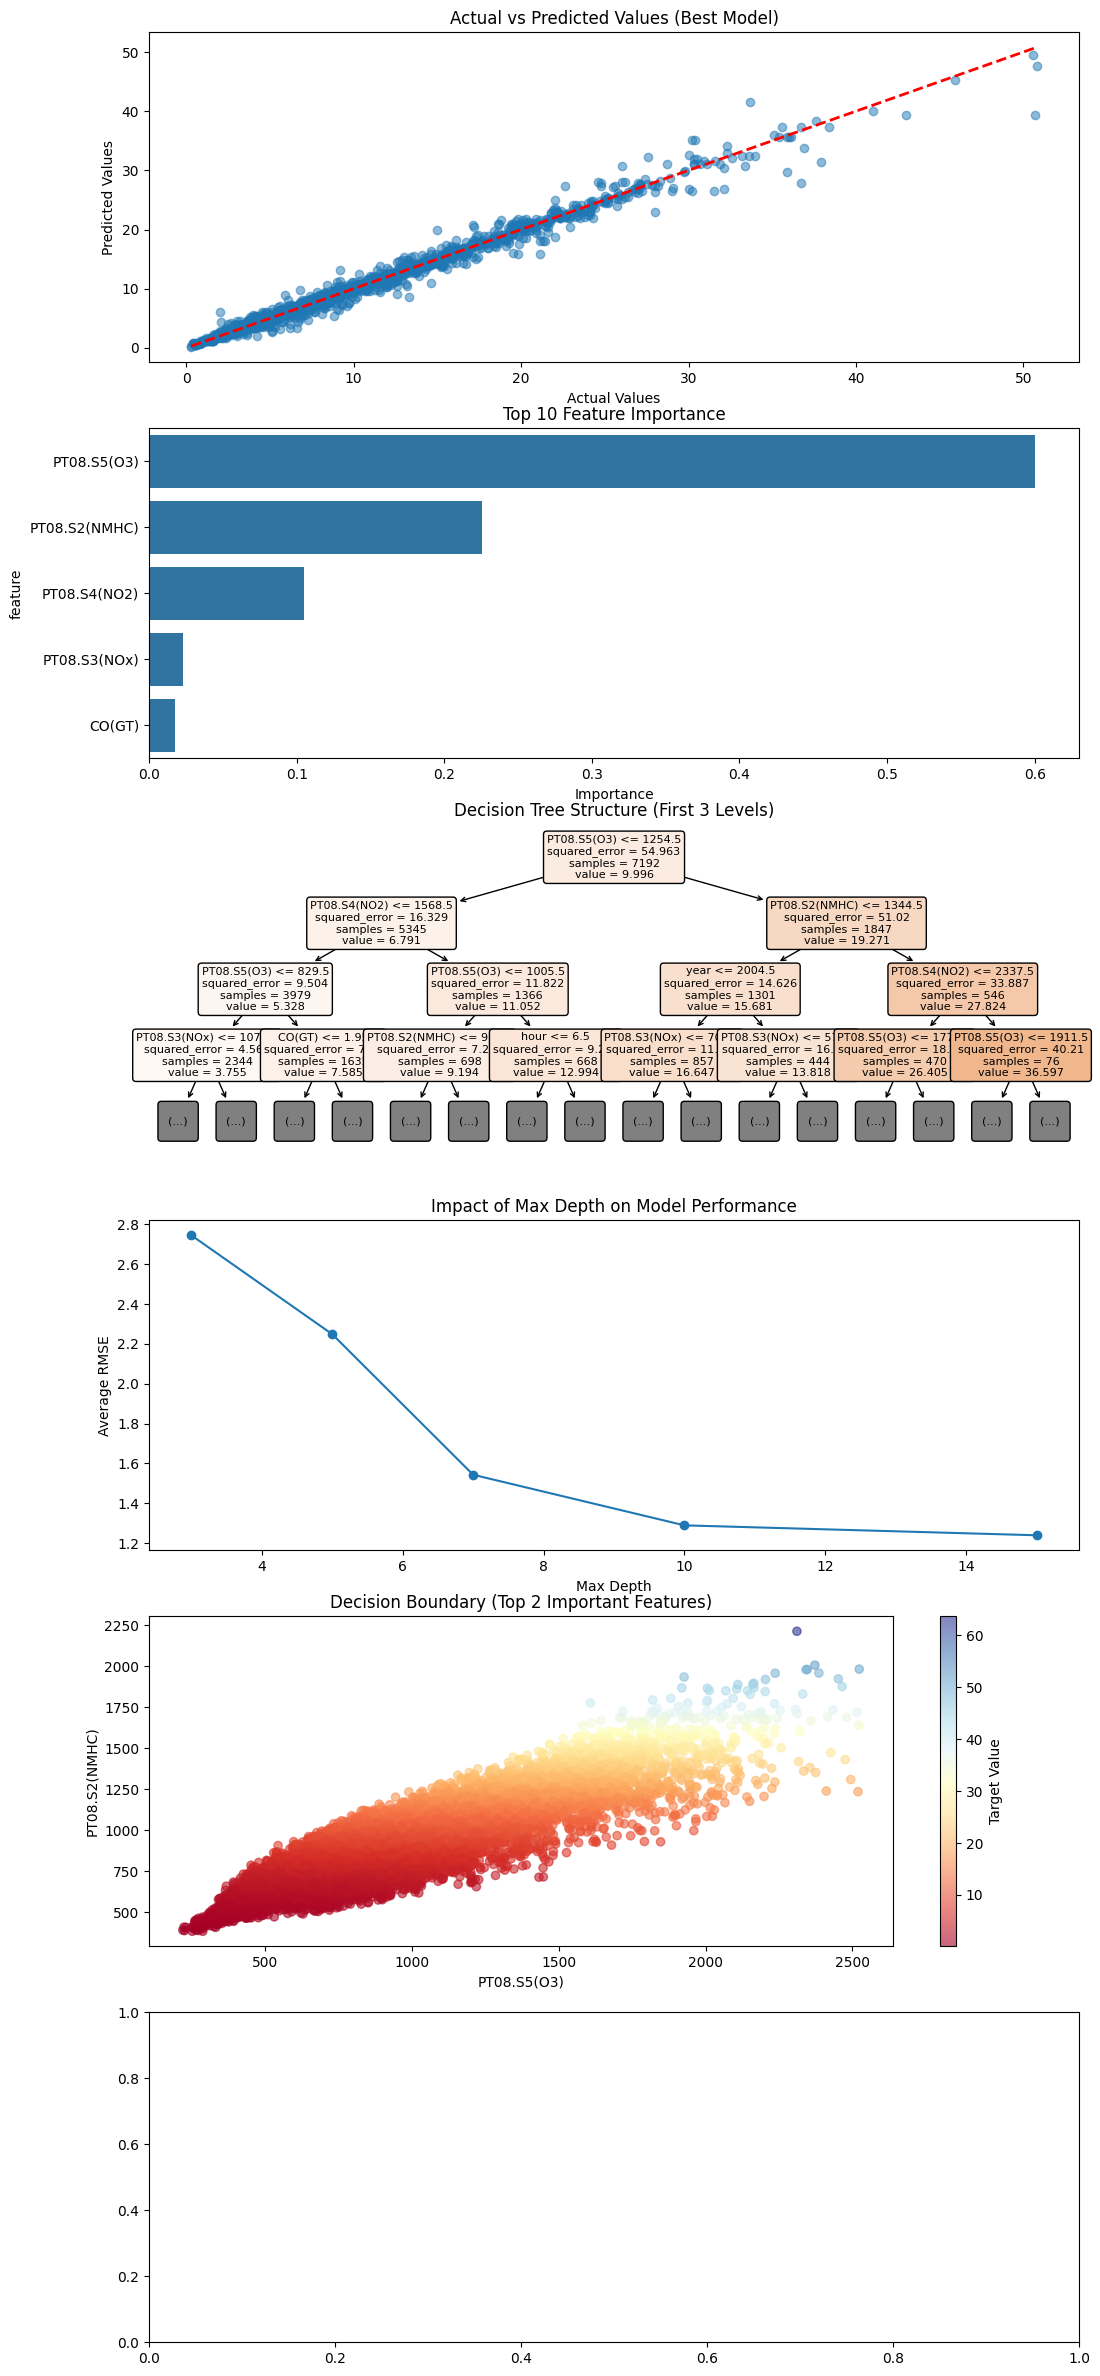

In [ ]:
best_model1, feature_importance1, grid_search1, pca1 ,decisiontree_metrics1  = analyze_decision_tree(df_cleaned)

I also tried the original data to see what would happen.

In [ ]:
best_model1, feature_importance1, grid_search1, pca1 ,decisiontree_metrics1  = analyze_decision_tree(df_original)

In [ ]:


def analyze_random_forest(df, test_size=0.2, random_state=42, param_grid=None):

    X = df_prepared.loc[:, df_prepared.columns != 'C6H6(GT)']
    y = df_prepared['C6H6(GT)']
    feature_names = X.columns


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    }


    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)


    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)


    rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
    rf_best.fit(X_train, y_train)


    cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print(f"Cross-Validation R² Scores: {cv_scores}")
    print(f"Mean CV R² Score: {np.mean(cv_scores):.2f}")


    y_pred = rf_best.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")


    def plot_learning_curve(model, X, y):
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', n_jobs=-1)
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
        plt.plot(train_sizes, test_mean, label='Cross-Validation Score', marker='o')
        plt.xlabel('Number of Training Samples')
        plt.ylabel('R² Score')
        plt.title('Learning Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    plot_learning_curve(rf_best, X, y)


    explainer = shap.Explainer(rf_best, X_train)
    shap_values = explainer(X_test)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

    importances = rf_best.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)

    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 5 Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction vs. Actual Plot')
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=30, kde=True, color='blue')
    plt.axvline(0, color='r', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution Plot')
    plt.grid(True)
    plt.show()


    return


Next, we will work with the Random Forest model, which is a bagging technique. It combines results to prevent overfitting, similar to averaging.  

The hyperparameters used here are mostly universal for tree-based models, such as `max_depth`, `min_samples_split`, and `min_samples_leaf`. However, `n_estimators` is specific to Random Forest, representing the number of estimators used for drawing general conclusions.  

Other hyperparameters control aspects like tree depth, node size, and minimum splitting criteria. Additionally, I plan to include a learning curve to better understand overfitting.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation R² Scores: [0.9940224  0.99546731 0.99611358 0.99732731 0.99572122]
Mean CV R² Score: 1.00
Mean Absolute Error (MAE): 0.25
Root Mean Squared Error (RMSE): 1.04
R² Score: 0.98


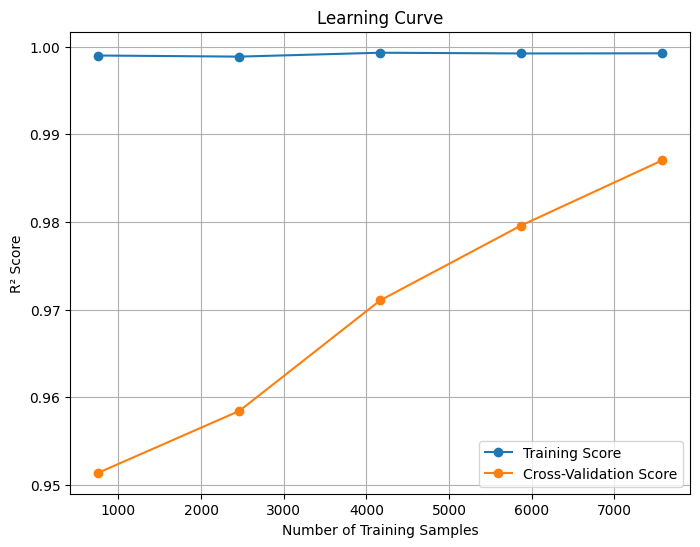

100%|===================| 1890/1895 [01:38<00:00]        

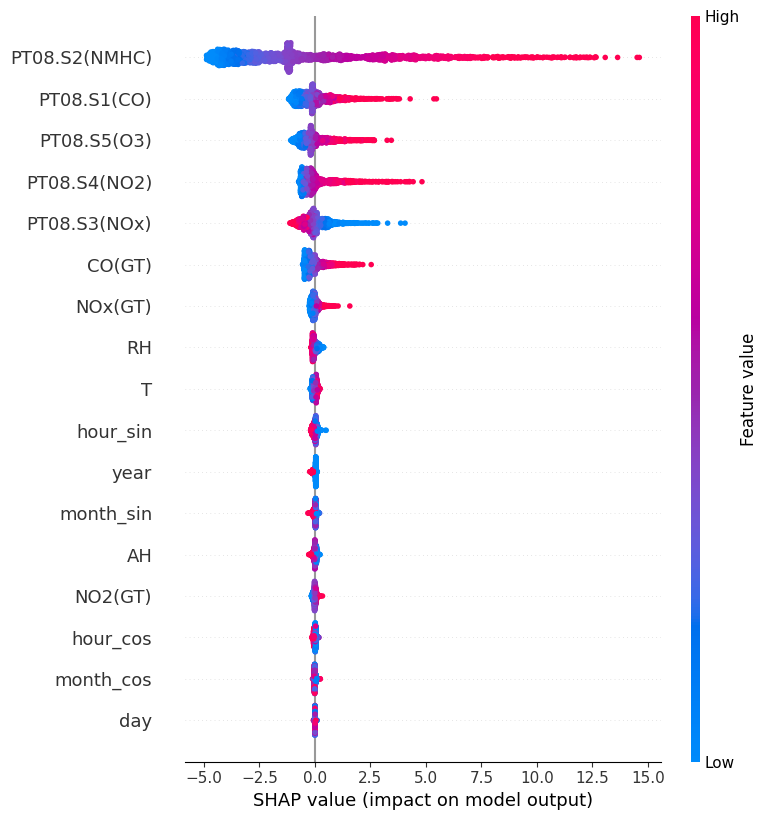

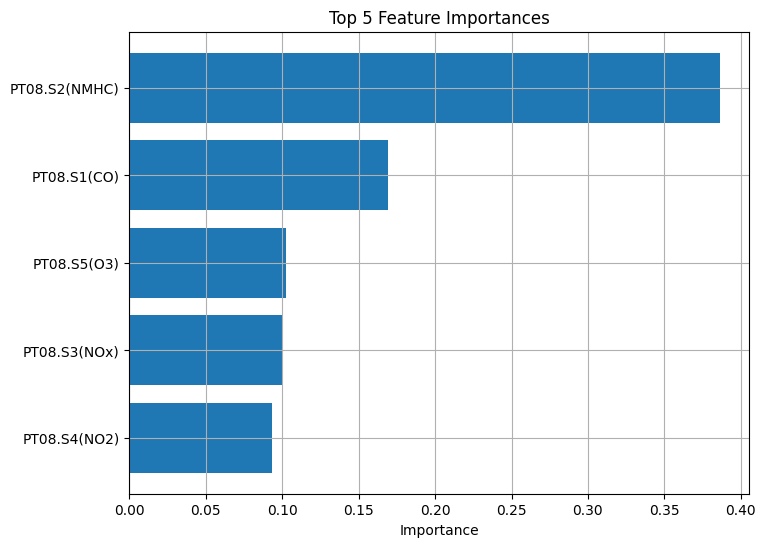

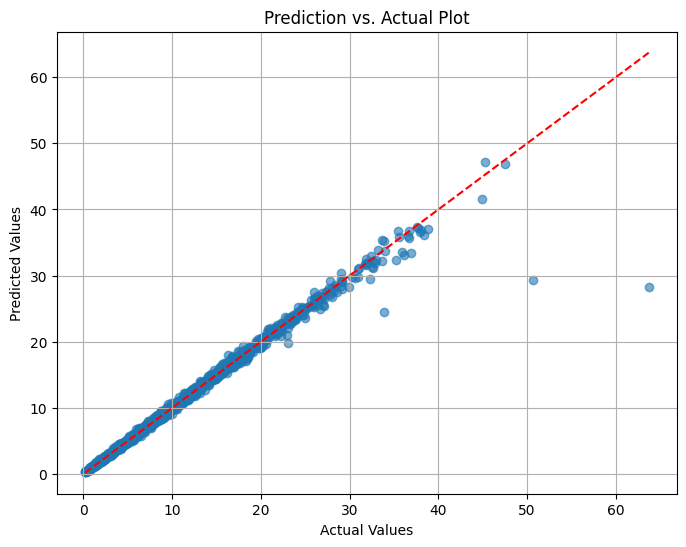

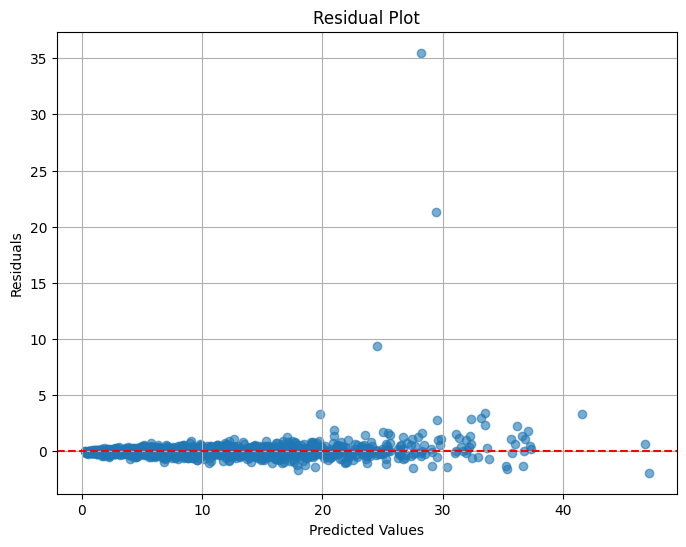

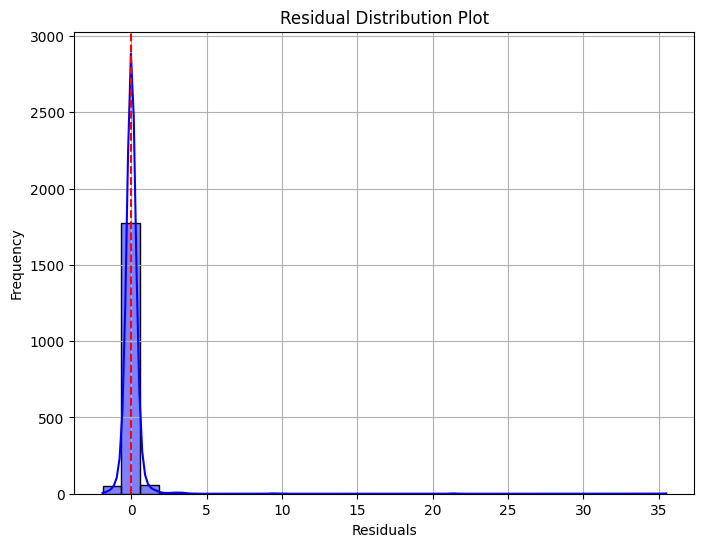

In [ ]:
analyze_random_forest(df_prepared)

I also tried running the model without handling the null values. Next, I will analyze the effects of handling null values, feature extraction, and other preprocessing steps.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation R² Scores: [0.9940224  0.99546731 0.99611358 0.99732731 0.99572122]
Mean CV R² Score: 1.00
Mean Absolute Error (MAE): 0.25
Root Mean Squared Error (RMSE): 1.04
R² Score: 0.98


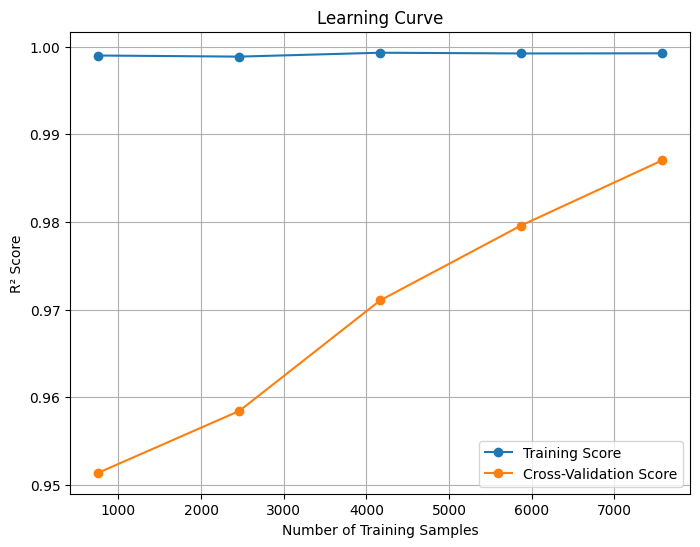

100%|===================| 1894/1895 [01:27<00:00]        

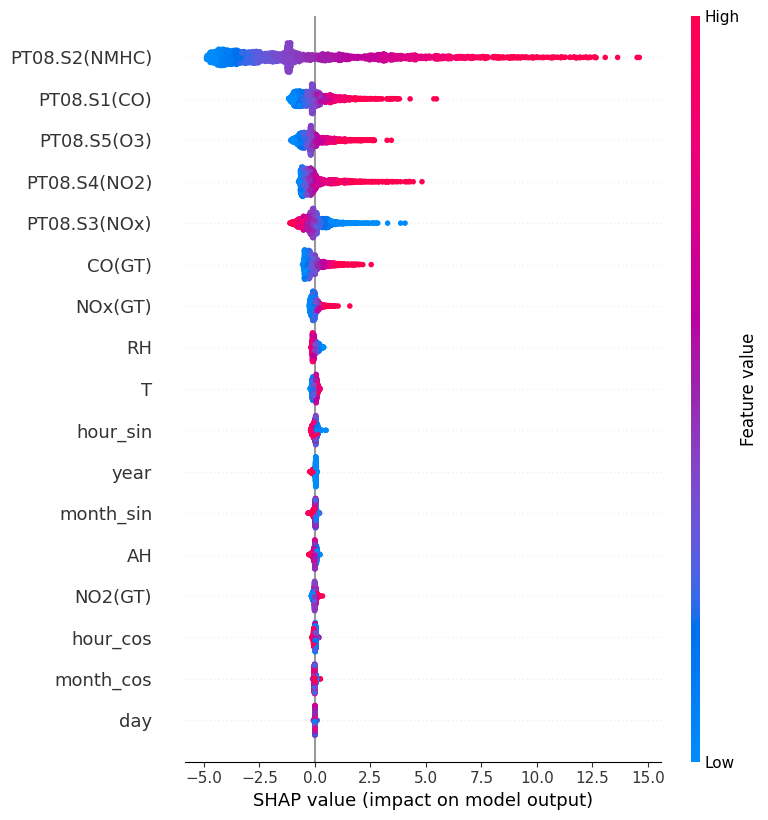

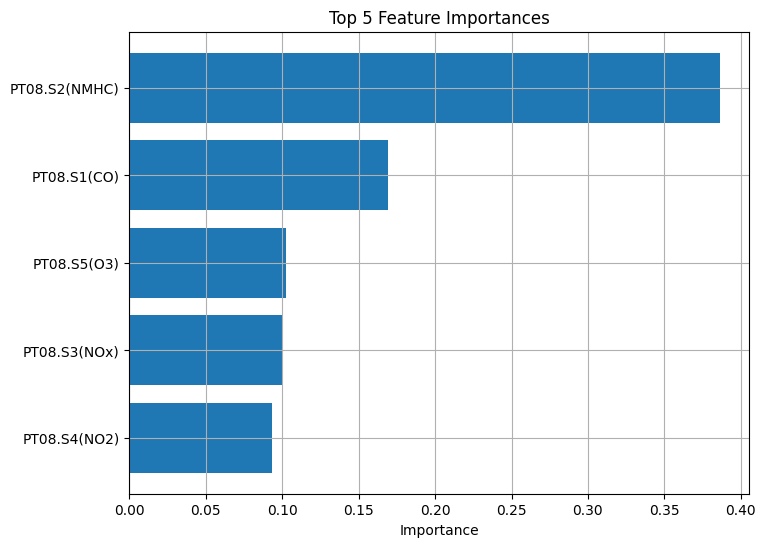

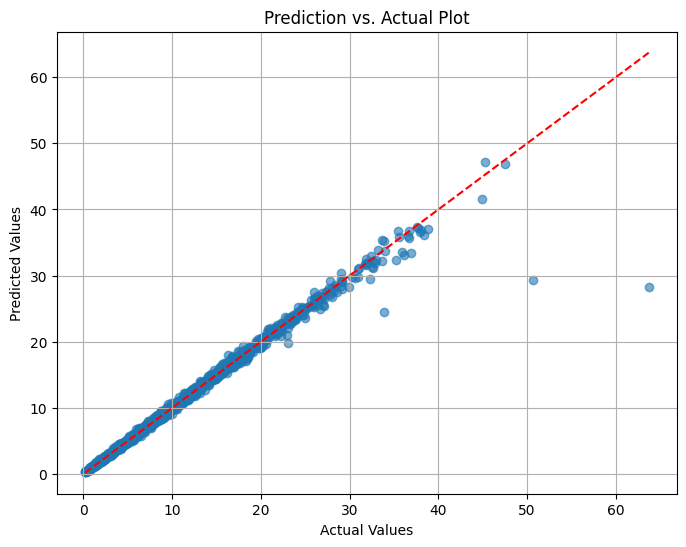

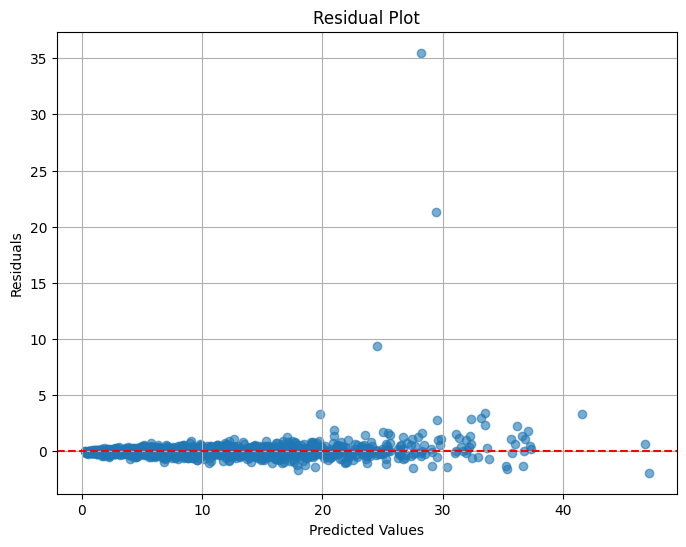

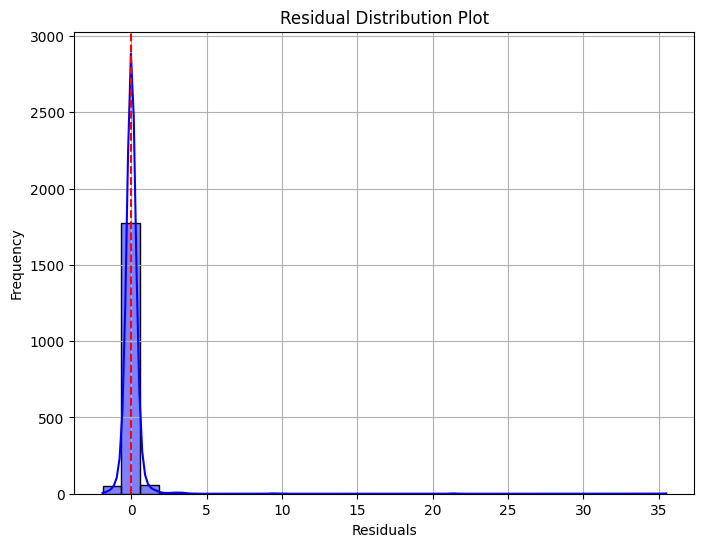

In [ ]:
analyze_random_forest(df_cleaned)

I also tried running the model with the original dataset.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation R² Scores: [0.9940224  0.99546731 0.99611358 0.99732731 0.99572122]
Mean CV R² Score: 1.00
Mean Absolute Error (MAE): 0.25
Root Mean Squared Error (RMSE): 1.04
R² Score: 0.98


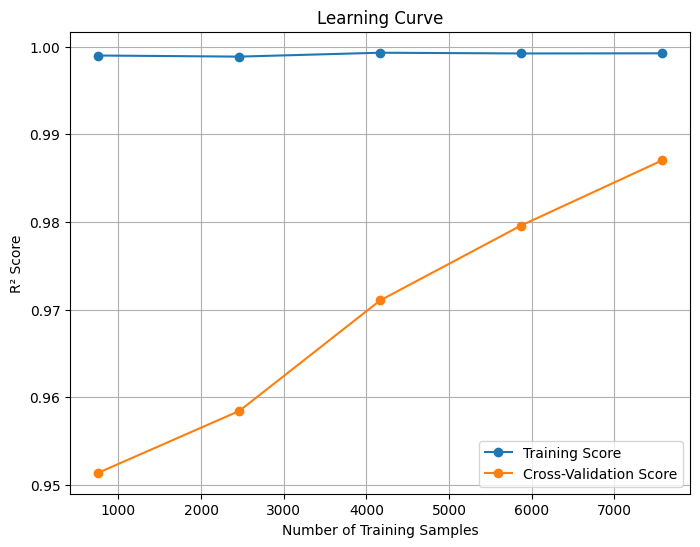

 99%|===================| 1880/1895 [01:31<00:00]        

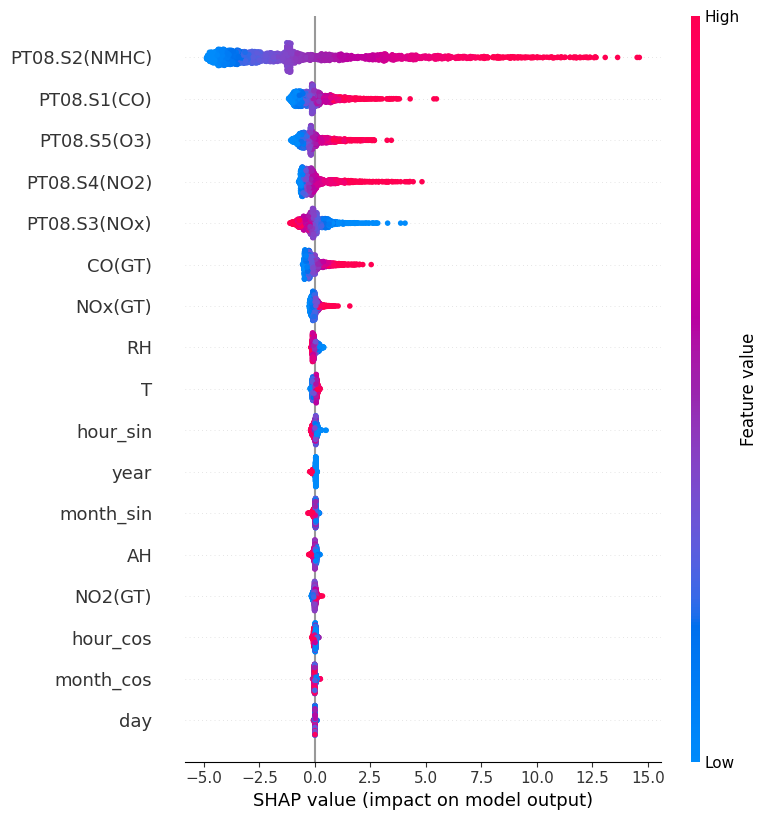

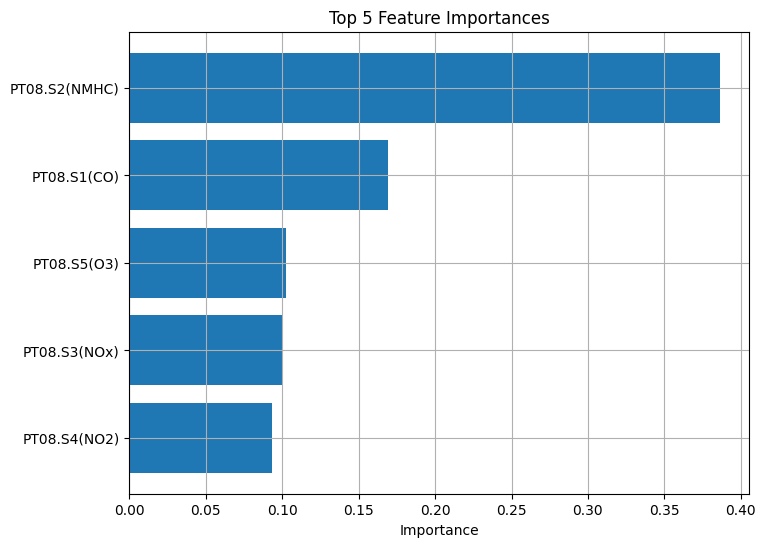

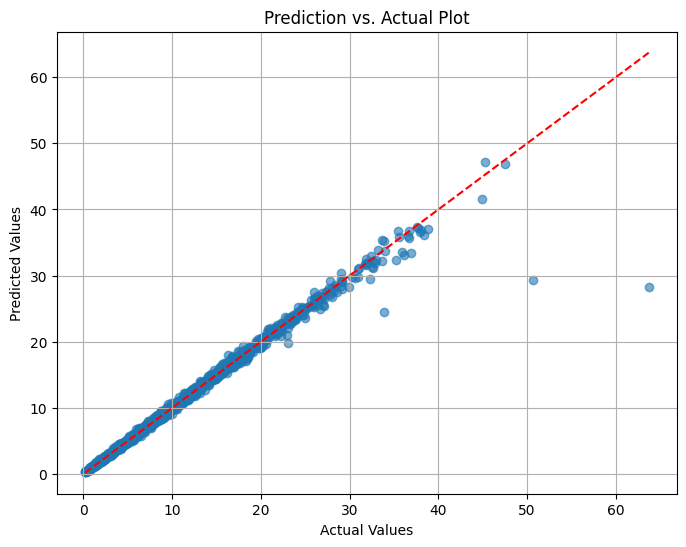

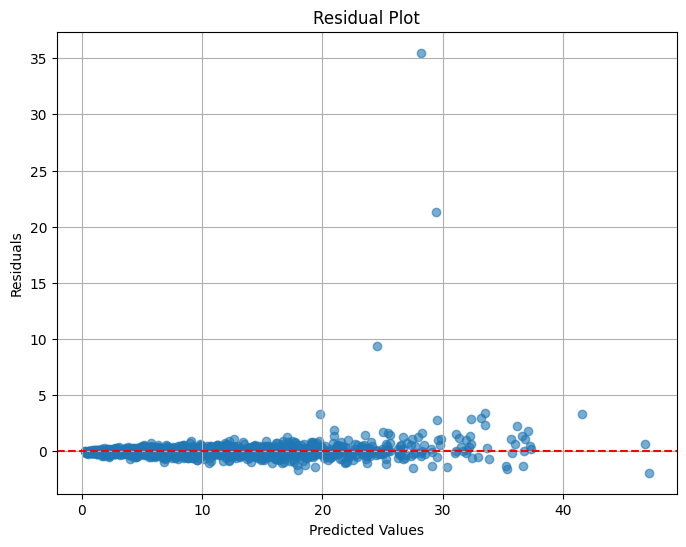

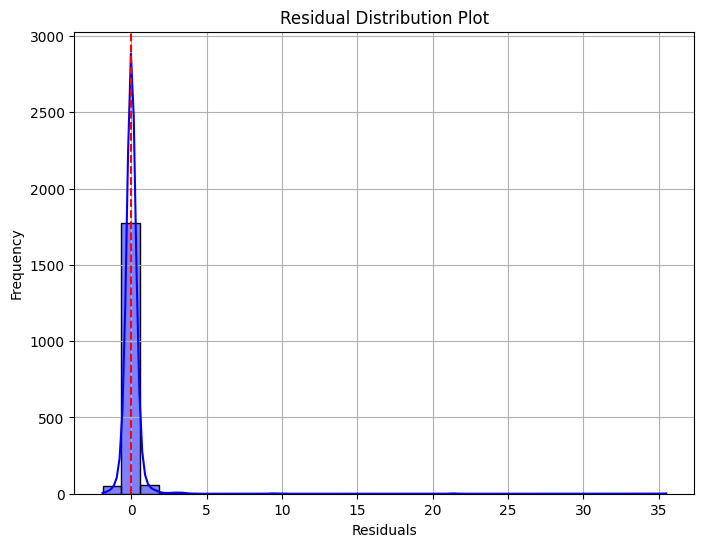

In [ ]:
analyze_random_forest(df_original)

Now, we will use boosting models, which summarize results iteratively to reach the next conclusion. Boosting is effective for capturing complex structures but carries a higher risk of overfitting, so proper generalization is essential.  

Regularization terms help mitigate overfitting. The *learning rate* hyperparameter can control overfitting by influencing how much each tree contributes to the model. The *sampling* hyperparameters determine what portion of the data is used for each iteration, similar to train-test splitting.

In [ ]:


def analyze_xgb(df):
    xgb.config_context(threads=-1)

    df = df.dropna(subset=['C6H6(GT)'])
    X = df.loc[:, df.columns != 'C6H6(GT)']
    y = df['C6H6(GT)']
    feature_names = X.columns


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def cv_score(params, X=X_train, y=y_train, nfold=5):
        dtrain = xgb.DMatrix(X, label=y)
        params['nthread'] = -1
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=nfold,
            metrics='rmse',
            early_stopping_rounds=50,
            verbose_eval=False
        )
        return cv_results['test-rmse-mean'].min()

    param_grids = [
        {
            'objective': 'reg:squarederror',
            'max_depth': max_depth,
            'learning_rate': lr,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': gamma,
            'min_child_weight': min_child_weight,
            'seed': 42,
            'nthread': -1
        }
        for max_depth in [3, 5, 7]
        for lr in [0.01, 0.1, 0.3]
        for gamma in [0, 0.1, 1]
        for min_child_weight in [1, 3, 5]
    ]

    print("Tuning learning rate, max depth, gamma, and min_child_weight...")
    cv_scores = []
    for params in param_grids:
        score = cv_score(params)
        cv_scores.append((score, params))

    best_score, best_params = min(cv_scores, key=lambda x: x[0])
    print(f"\nBest parameters from first grid:\n{best_params}")
    print(f"Best CV RMSE: {best_score}")

    second_param_grids = [
        {**best_params,
         'subsample': subsample,
         'colsample_bytree': colsample
        }
        for subsample in [0.6, 0.8, 1.0]
        for colsample in [0.6, 0.8, 1.0]
    ]

    print("\nTuning subsample and colsample_bytree...")
    cv_scores = []
    for params in second_param_grids:
        score = cv_score(params)
        cv_scores.append((score, params))

    best_score, final_params = min(cv_scores, key=lambda x: x[0])
    print(f"\nFinal best parameters:\n{final_params}")
    print(f"Final best CV RMSE: {best_score}")


    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    eval_list = [(dtest, 'eval'), (dtrain, 'train')]
    final_model = xgb.train(
        final_params,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=50,
        evals=eval_list,
        verbose_eval=False
    )


    y_pred = final_model.predict(dtest)


    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\nFinal Model Performance Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")


    explainer = shap.Explainer(final_model, X_train)
    shap_values = explainer(X_test)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)


    importance_scores = final_model.get_score(importance_type='weight')
    importance_df = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    }).sort_values('Importance', ascending=False).head(5)

    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 5 Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction vs. Actual Plot')
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=30, kde=True, color='blue')
    plt.axvline(0, color='r', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution Plot')
    plt.grid(True)
    plt.show()

    return


Tuning learning rate, max depth, gamma, and min_child_weight...

Best parameters from first grid:
{'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'min_child_weight': 5, 'seed': 42, 'nthread': -1}
Best CV RMSE: 0.2049408985050344

Tuning subsample and colsample_bytree...

Final best parameters:
{'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'min_child_weight': 5, 'seed': 42, 'nthread': -1}
Final best CV RMSE: 0.1809616467793611

Final Model Performance Metrics:
Mean Absolute Error (MAE): 0.08
Root Mean Squared Error (RMSE): 0.61
R² Score: 0.99


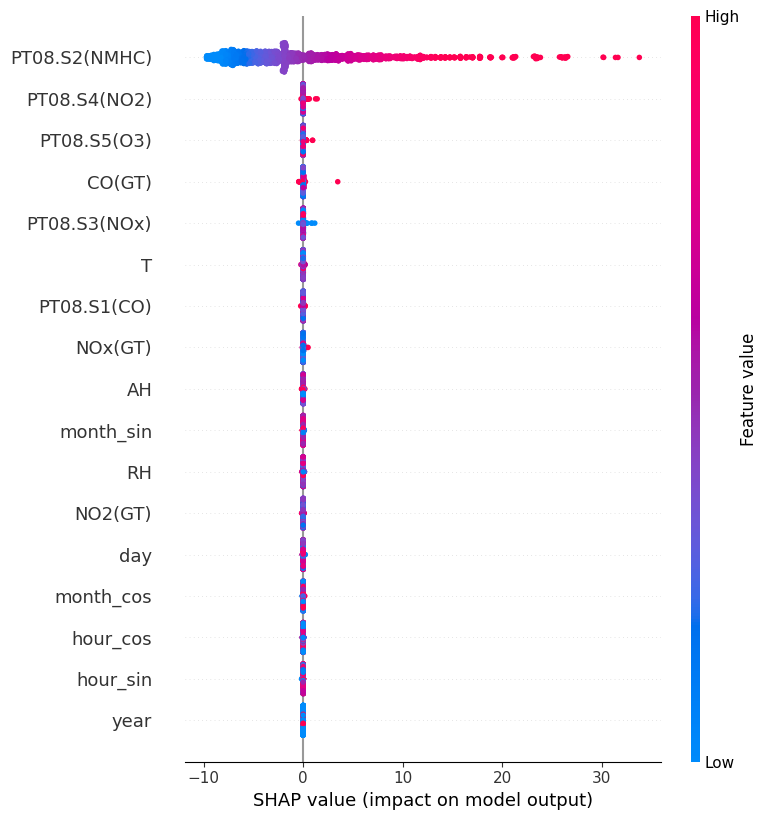

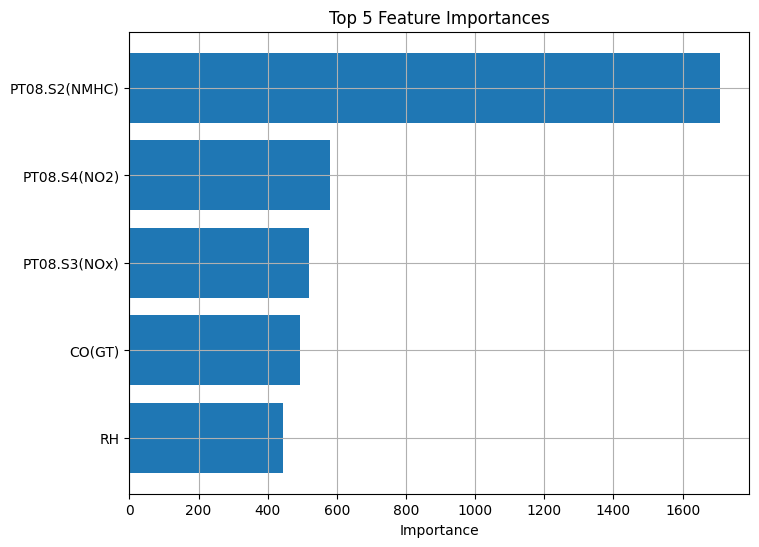

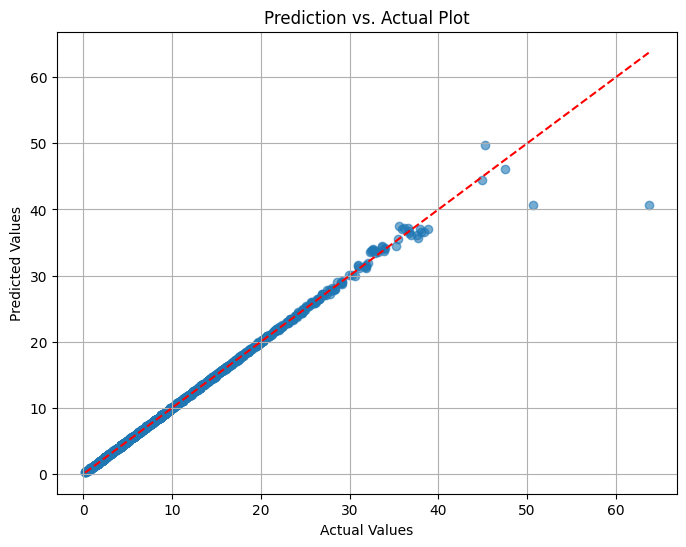

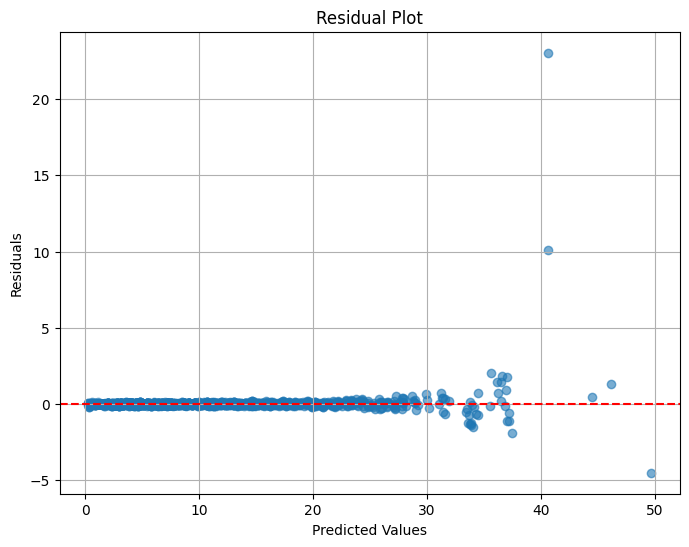

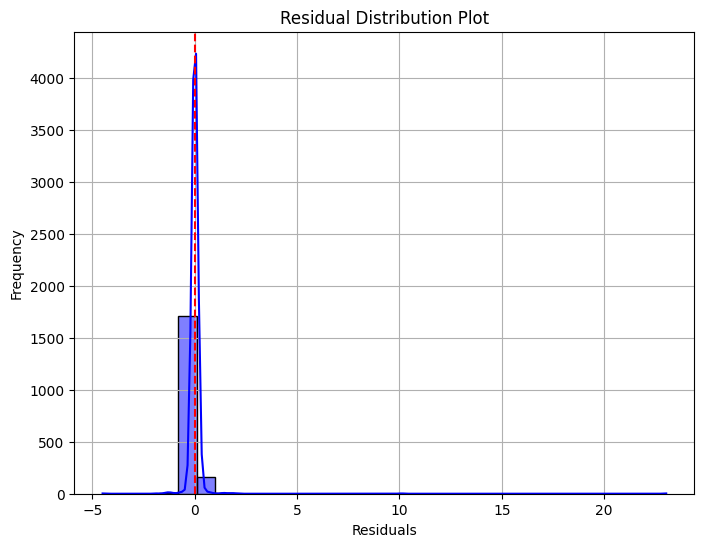

In [ ]:
analyze_xgb(df_prepared)

In the SHAP visualization, *PT08.S2* shows a higher effect than the others. I am unsure if this is normal or if I made a mistake. I might have done something wrong here, and I will focus on this next time. Also, when looking at the results, overfitting seems very likely.

Tuning learning rate, max depth, gamma, and min_child_weight...

Best parameters from first grid:
{'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'min_child_weight': 3, 'seed': 42, 'nthread': -1}
Best CV RMSE: 0.3410593840138012

Tuning subsample and colsample_bytree...

Final best parameters:
{'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'min_child_weight': 3, 'seed': 42, 'nthread': -1}
Final best CV RMSE: 0.3107050631574667

Final Model Performance Metrics:
Mean Absolute Error (MAE): 0.07
Root Mean Squared Error (RMSE): 0.24
R² Score: 1.00


 98%|===================| 1757/1799 [00:15<00:00]        

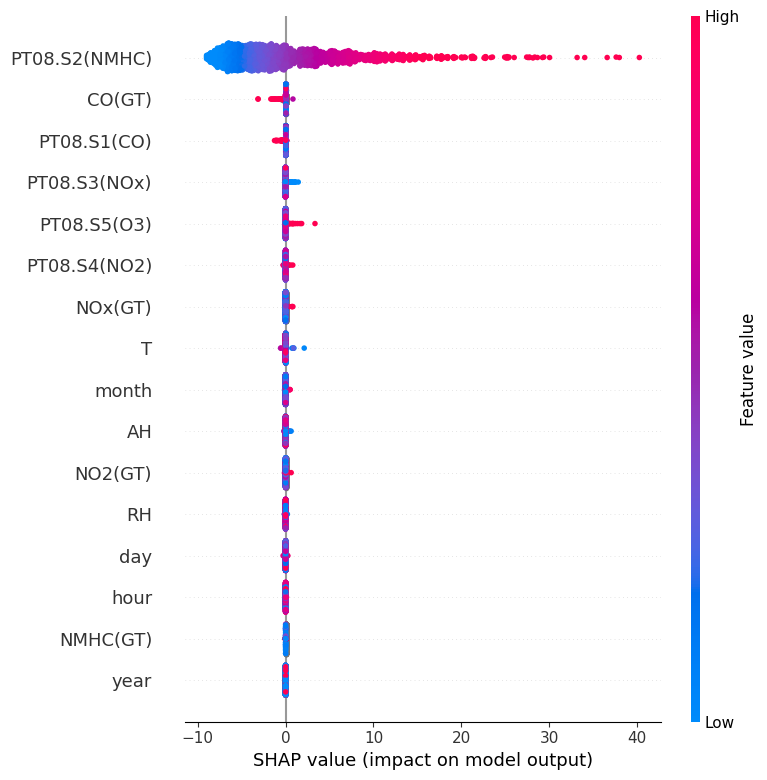

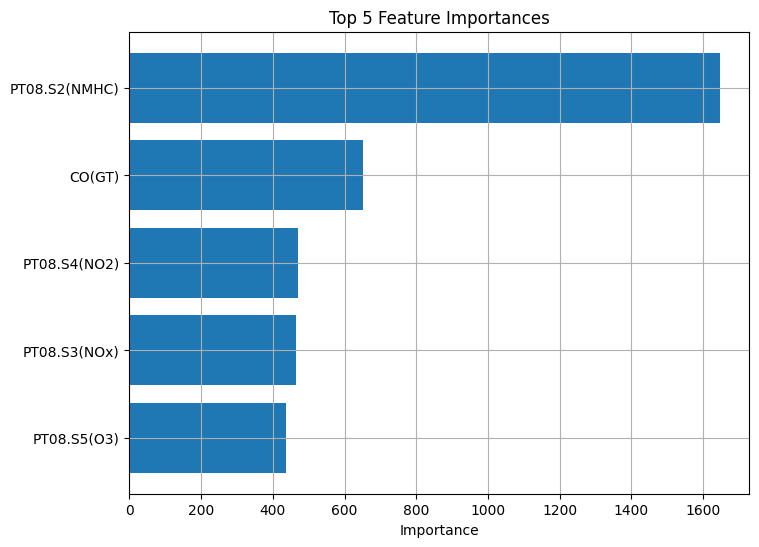

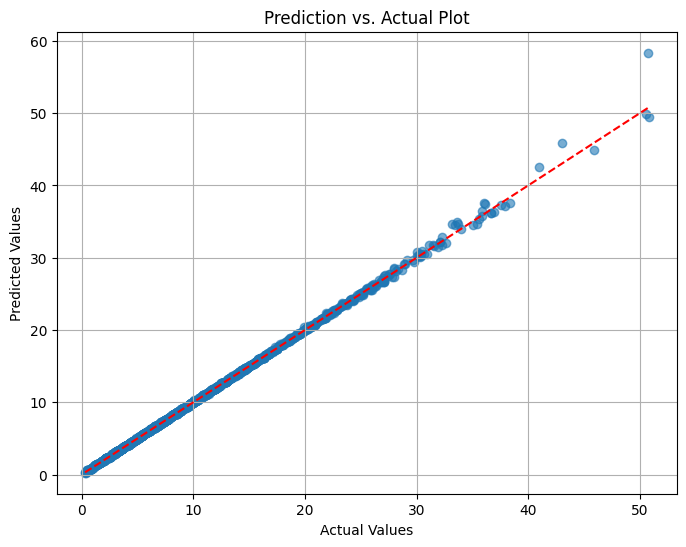

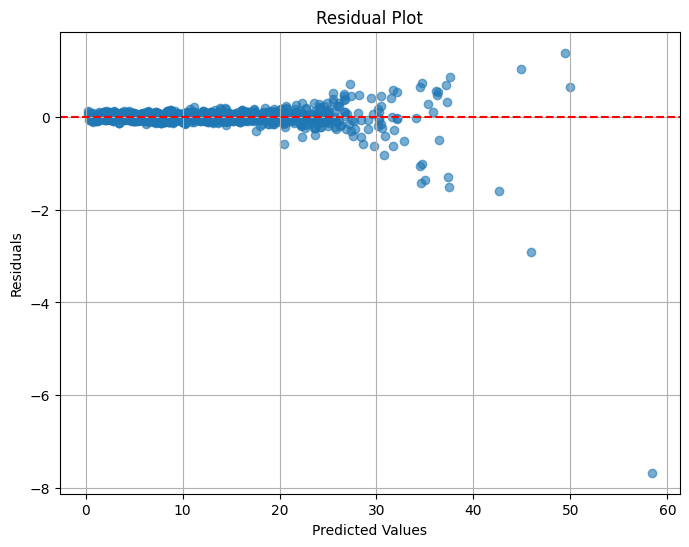

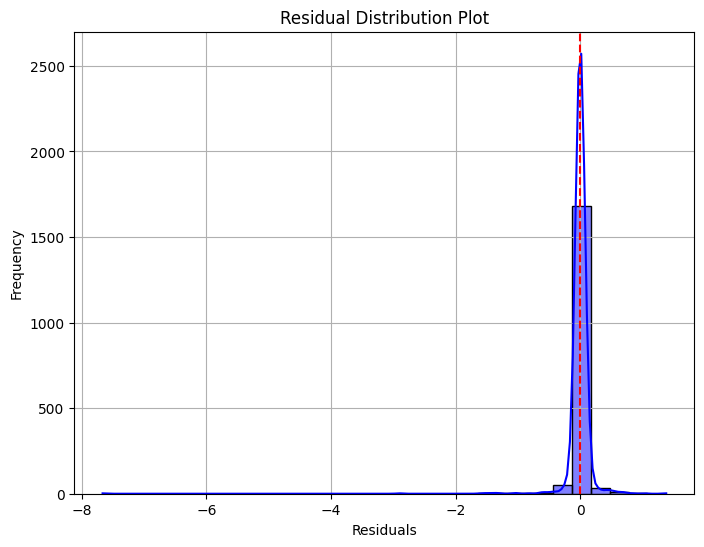

In [ ]:
analyze_xgb(df_cleaned)

In [ ]:


def analyze_xgb_original(df):
    xgb.config_context(threads=-1)

    df = df.drop(columns=['Date', 'Time'], errors='ignore')
    df = df.dropna(subset=['C6H6(GT)'])
    X = df.loc[:, df.columns != 'C6H6(GT)']
    y = df['C6H6(GT)']
    feature_names = X.columns


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def cv_score(params, X=X_train, y=y_train, nfold=5):
        dtrain = xgb.DMatrix(X, label=y)
        params['nthread'] = -1
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=nfold,
            metrics='rmse',
            early_stopping_rounds=50,
            verbose_eval=False
        )
        return cv_results['test-rmse-mean'].min()

    param_grids = [
        {
            'objective': 'reg:squarederror',
            'max_depth': max_depth,
            'learning_rate': lr,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': gamma,
            'min_child_weight': min_child_weight,
            'seed': 42,
            'nthread': -1
        }
        for max_depth in [3, 5, 7]
        for lr in [0.01, 0.1, 0.3]
        for gamma in [0, 0.1, 1]
        for min_child_weight in [1, 3, 5]
    ]


    print("Tuning learning rate, max depth, gamma, and min_child_weight...")
    cv_scores = []
    for params in param_grids:
        score = cv_score(params)
        cv_scores.append((score, params))

    best_score, best_params = min(cv_scores, key=lambda x: x[0])
    print(f"\nBest parameters from first grid:\n{best_params}")
    print(f"Best CV RMSE: {best_score}")

    second_param_grids = [
        {**best_params,
         'subsample': subsample,
         'colsample_bytree': colsample
        }
        for subsample in [0.6, 0.8, 1.0]
        for colsample in [0.6, 0.8, 1.0]
    ]

    print("\nTuning subsample and colsample_bytree...")
    cv_scores = []
    for params in second_param_grids:
        score = cv_score(params)
        cv_scores.append((score, params))

    best_score, final_params = min(cv_scores, key=lambda x: x[0])
    print(f"\nFinal best parameters:\n{final_params}")
    print(f"Final best CV RMSE: {best_score}")

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    eval_list = [(dtest, 'eval'), (dtrain, 'train')]
    final_model = xgb.train(
        final_params,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=50,
        evals=eval_list,
        verbose_eval=False
    )


    y_pred = final_model.predict(dtest)


    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\nFinal Model Performance Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")


    explainer = shap.Explainer(final_model, X_train)
    shap_values = explainer(X_test)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

    importance_scores = final_model.get_score(importance_type='weight')
    importance_df = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    }).sort_values('Importance', ascending=False).head(5)

    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 5 Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction vs. Actual Plot')
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=30, kde=True, color='blue')
    plt.axvline(0, color='r', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution Plot')
    plt.grid(True)
    plt.show()

    return


In the original dataset, *PT08.S2* is a problem, but how is it possible that other features have nearly no explainable power? I need to investigate and understand this in detail, especially by analyzing the SHAP graph.

Tuning learning rate, max depth, gamma, and min_child_weight...

Best parameters from first grid:
{'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 0.3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'min_child_weight': 1, 'seed': 42, 'nthread': -1}
Best CV RMSE: 0.36575348422468207

Tuning subsample and colsample_bytree...

Final best parameters:
{'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 0.3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'min_child_weight': 1, 'seed': 42, 'nthread': -1}
Final best CV RMSE: 0.3181817446995129

Final Model Performance Metrics:
Mean Absolute Error (MAE): 0.07
Root Mean Squared Error (RMSE): 0.28
R² Score: 1.00


 97%|=================== | 1824/1872 [00:31<00:00]       

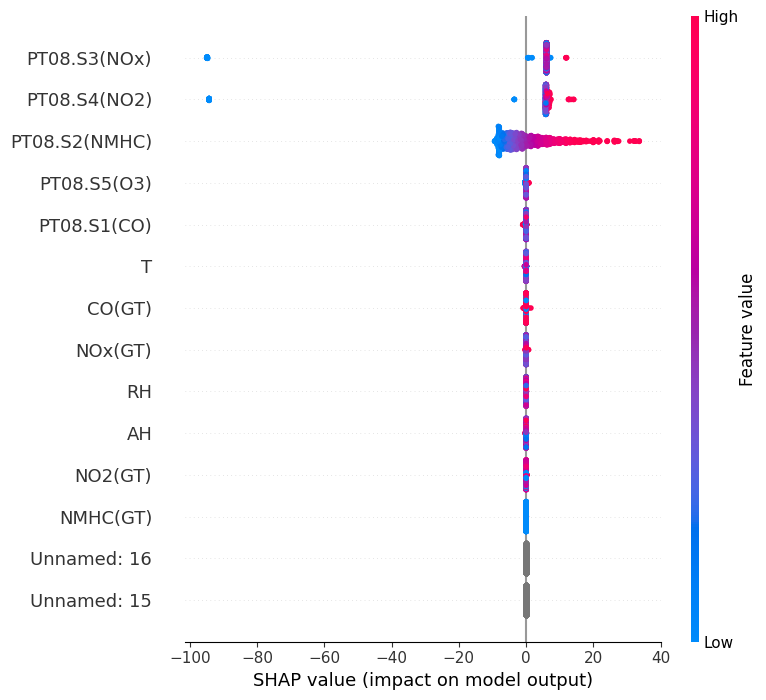

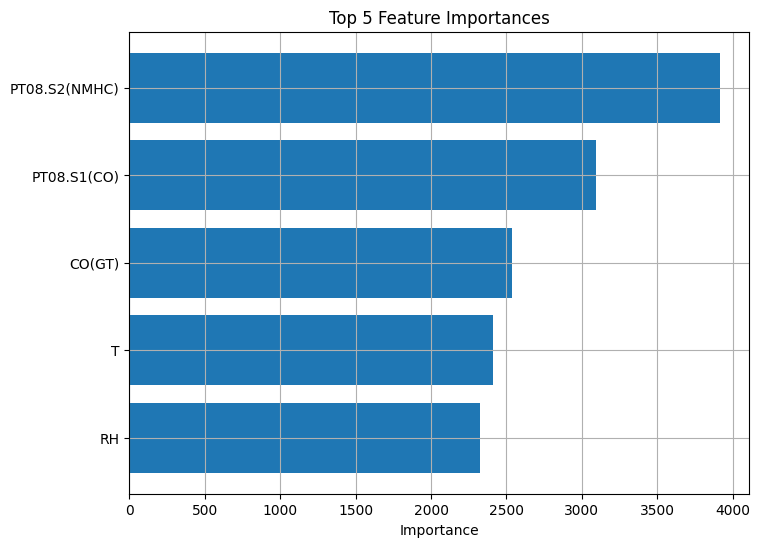

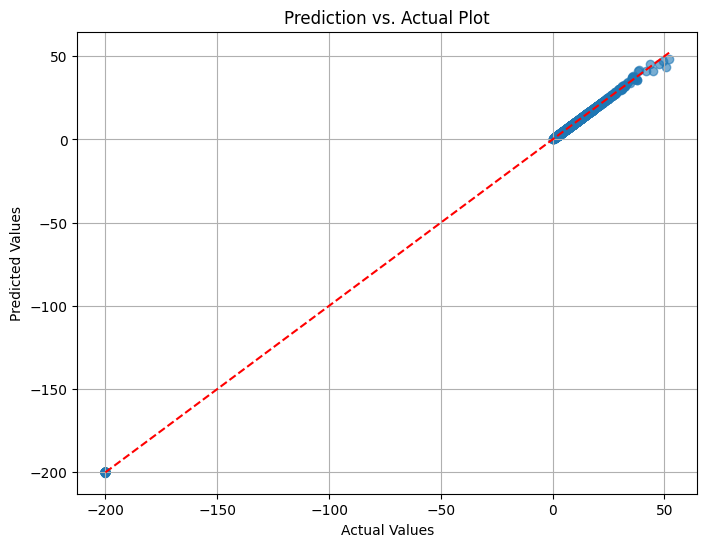

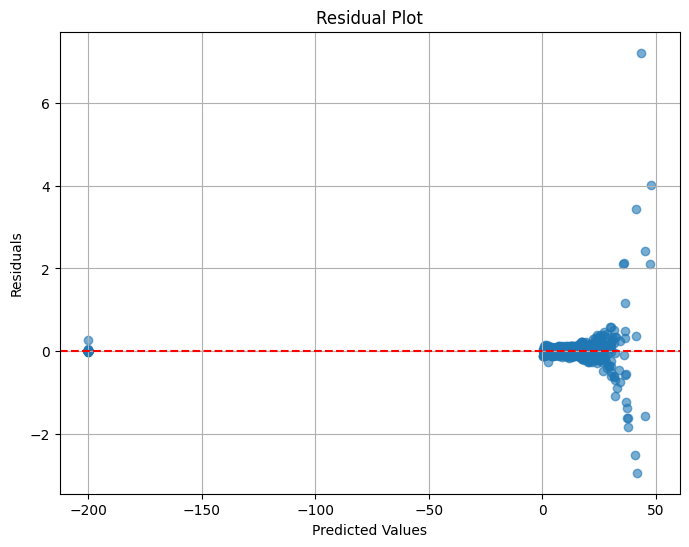

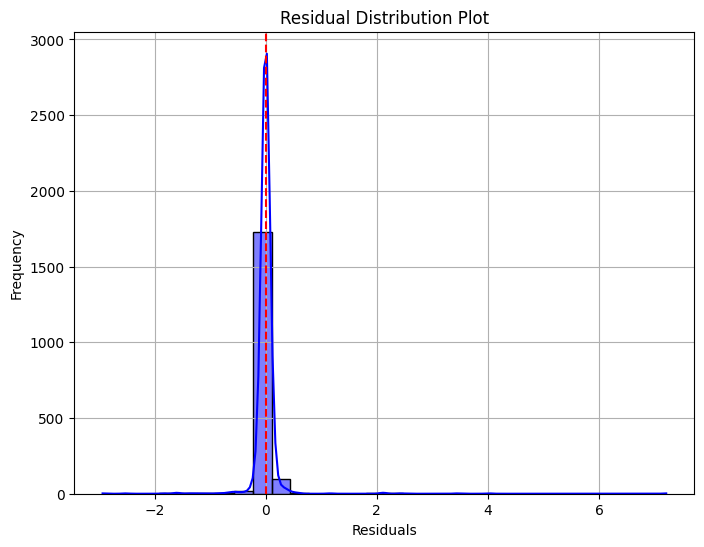

In [ ]:
analyze_xgb_original(df_original)

Random Forest is the best option for this task. It outperforms Decision Trees and is more interpretable than boosting models. However, for larger datasets, boosting models might be more appropriate due to their flexibility.

Classification Part

Importing necessary libraries is generally a good practice as it reduces dependencies between specific cells.

I will read the CSV file from my GitHub repository; I think this is better than using Google Drive.

In [ ]:
url = 'https://raw.githubusercontent.com/mtech00/EPAM_DS/refs/heads/main/weatherAUS.csv'

df = pd.read_csv(url)
pd.set_option('display.max_columns', None)

After this point, we will see how big it is.  
What are the features? (Feature as a method of defining data. For example, eye color is a feature for defining humans, where "eye color = feature, feature = value.")  
What kind of data is this? Is it just simple "yes/no," "1/0," or enormously large numbers with 32-bit floats?  
All of these will provide us with insightful information.

In [ ]:
df.shape

(145460, 23)

In [ ]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [ ]:
df.head(5).T

0           1           2           3           4
Date           2008-12-01  2008-12-02  2008-12-03  2008-12-04  2008-12-05
Location           Albury      Albury      Albury      Albury      Albury
MinTemp              13.4         7.4        12.9         9.2        17.5
MaxTemp              22.9        25.1        25.7        28.0        32.3
Rainfall              0.6         0.0         0.0         0.0         1.0
Evaporation           NaN         NaN         NaN         NaN         NaN
Sunshine              NaN         NaN         NaN         NaN         NaN
WindGustDir             W         WNW         WSW          NE           W
WindGustSpeed        44.0        44.0        46.0        24.0        41.0
WindDir9am              W         NNW           W          SE         ENE
WindDir3pm            WNW         WSW         WSW           E          NW
WindSpeed9am         20.0         4.0        19.0        11.0         7.0
WindSpeed3pm         24.0        22.0        26.0         9.0        20.0
Humidity9am          71.0        44.0        38.0        45.0        82.0
Humidity3pm          22.0        25.0        30.0        16.0        33.0
Pressure9am        1007.7      1010.6      1007.6      1017.6      1010.8
Pressure3pm        1007.1      1007.8      1008.7      1012.8      1006.0
Cloud9am              8.0         NaN         NaN         NaN         7.0
Cloud3pm              NaN         NaN         2.0         NaN         8.0
Temp9am              16.9        17.2        21.0        18.1        17.8
Temp3pm              21.8        24.3        23.2        26.5        29.7
RainToday              No          No          No          No          No
RainTomorrow           No          No          No          No          No

After observing that we have ordinal and nominal data, we understand what belongs in our ordinal category. Defining eye color might be a simple task (e.g., blue, brown), as the possible scenarios are very limited. However, when trying to define an animal's eye size, the data becomes much more diverse—you cannot count all possible values. This information provides insight into our dataset and how it is distributed or sparse.  

Additionally, adding kurtosis values would be a good practice (though we won't do so here).

In [ ]:
df.describe().T

count         mean        std    min     25%     50%  \
MinTemp        143975.0    12.194034   6.398495   -8.5     7.6    12.0   
MaxTemp        144199.0    23.221348   7.119049   -4.8    17.9    22.6   
Rainfall       142199.0     2.360918   8.478060    0.0     0.0     0.0   
Evaporation     82670.0     5.468232   4.193704    0.0     2.6     4.8   
Sunshine        75625.0     7.611178   3.785483    0.0     4.8     8.4   
WindGustSpeed  135197.0    40.035230  13.607062    6.0    31.0    39.0   
WindSpeed9am   143693.0    14.043426   8.915375    0.0     7.0    13.0   
WindSpeed3pm   142398.0    18.662657   8.809800    0.0    13.0    19.0   
Humidity9am    142806.0    68.880831  19.029164    0.0    57.0    70.0   
Humidity3pm    140953.0    51.539116  20.795902    0.0    37.0    52.0   
Pressure9am    130395.0  1017.649940   7.106530  980.5  1012.9  1017.6   
Pressure3pm    130432.0  1015.255889   7.037414  977.1  1010.4  1015.2   
Cloud9am        89572.0     4.447461   2.887159    0.0     1.0     5.0   
Cloud3pm        86102.0     4.509930   2.720357    0.0     2.0     5.0   
Temp9am        143693.0    16.990631   6.488753   -7.2    12.3    16.7   
Temp3pm        141851.0    21.683390   6.936650   -5.4    16.6    21.1   

                  75%     max  
MinTemp          16.9    33.9  
MaxTemp          28.2    48.1  
Rainfall          0.8   371.0  
Evaporation       7.4   145.0  
Sunshine         10.6    14.5  
WindGustSpeed    48.0   135.0  
WindSpeed9am     19.0   130.0  
WindSpeed3pm     24.0    87.0  
Humidity9am      83.0   100.0  
Humidity3pm      66.0   100.0  
Pressure9am    1022.4  1041.0  
Pressure3pm    1020.0  1039.6  
Cloud9am          7.0     9.0  
Cloud3pm          7.0     9.0  
Temp9am          21.6    40.2  
Temp3pm          26.4    46.7

When you look at the numbers, you might notice unusual things. Why do they mention "non-null"? Or why do different columns have different counts?  

This happens because, in the real world, you don’t always have answers to all questions. Sometimes it’s the nature of the data, and sometimes it’s due to life’s challenges. For example, if you want to learn about eye color, what happens if the creature doesn’t have eyes? That’s just the nature of the data.  

Alternatively, real-life challenges such as surveys can lead to missing information. Some people might not want to share their eye color but still provide all other details. For these reasons, we will always encounter missing parts in datasets.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Above, I mentioned whether the data is normally distributed or not—why is this important?  

In nature, you will often see examples of normal (or Gaussian) distribution. Here, it matters because depending on this, we decide how to handle missing values or apply statistical tools. Many statistical methods assume normal distribution (though I did not use it here, it is generally a better practice).  

Now, we will draw a KDE histogram. Histograms are well-known to many people.  
Why? Is it inherently important for humans? Of course not; they didn’t naturally learn it. However, they can intuitively understand it, which is why histograms are a common practice.  

In our example, we will visually examine the distribution of our data. In the first example, it is very close to a normal distribution.  

There is an extra line on the graphic—what is it? It is closely related to the bars. Why?  
This is the KDE (Kernel Density Estimate). It helps make spotting trends and patterns easier compared to the raw histogram alone, as it estimates probability density.  

Next, side by side, we will add a new visual element: the quartile-to-quartile (Q-Q) plot.  

Using values like 0.25 and 0.75, we gain insight into whether our data is normally distributed or skewed. If the data points closely follow the line, it means the distribution is very close to normal.

In [ ]:


url = "https://upload.wikimedia.org/wikipedia/commons/1/1a/Boxplot_vs_PDF.svg"

display.Image(url=url)


Cloud will be either ordinal or nominal—I couldn’t decide, so let the data type determine it (though this is not a good practice).

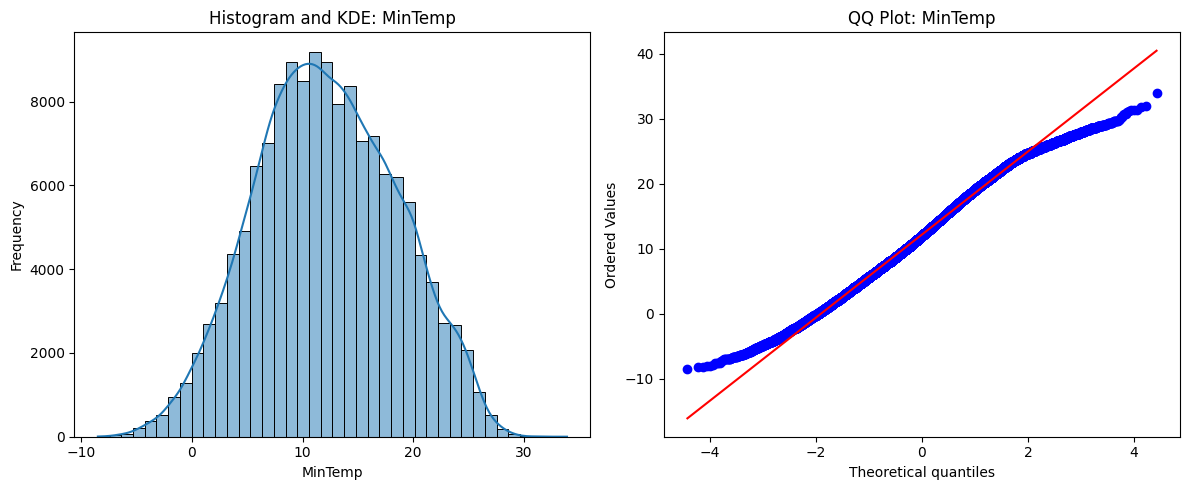

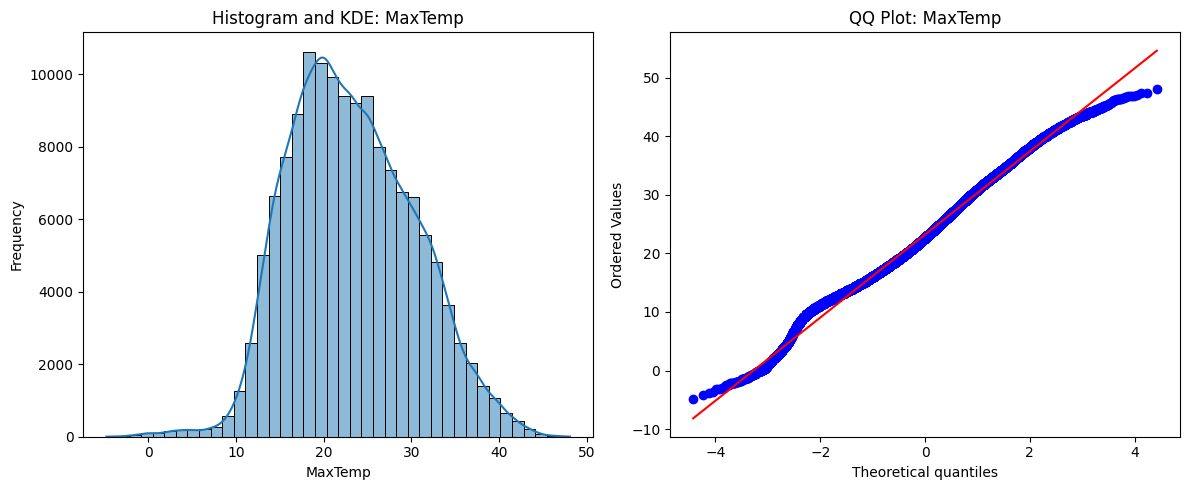

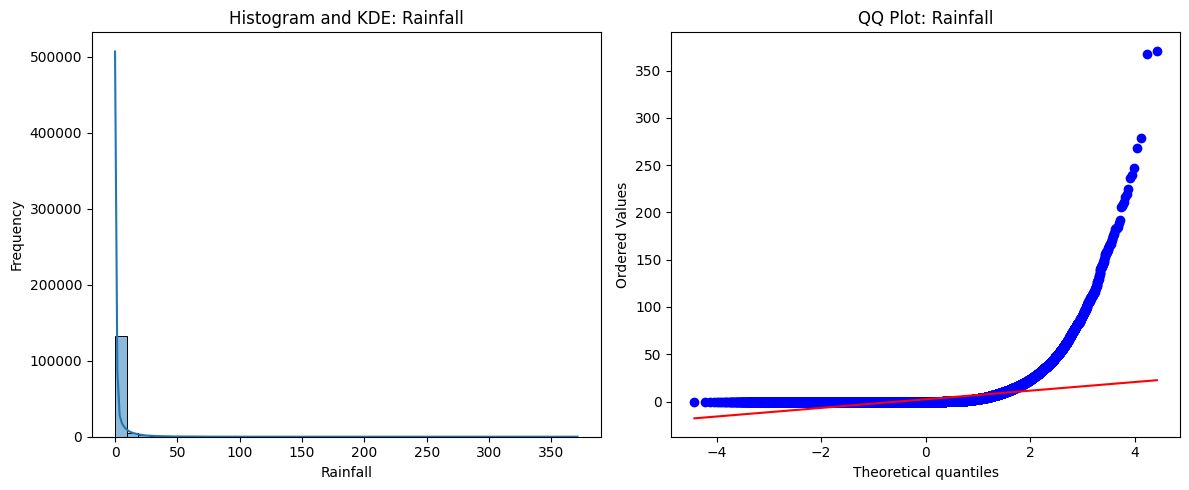

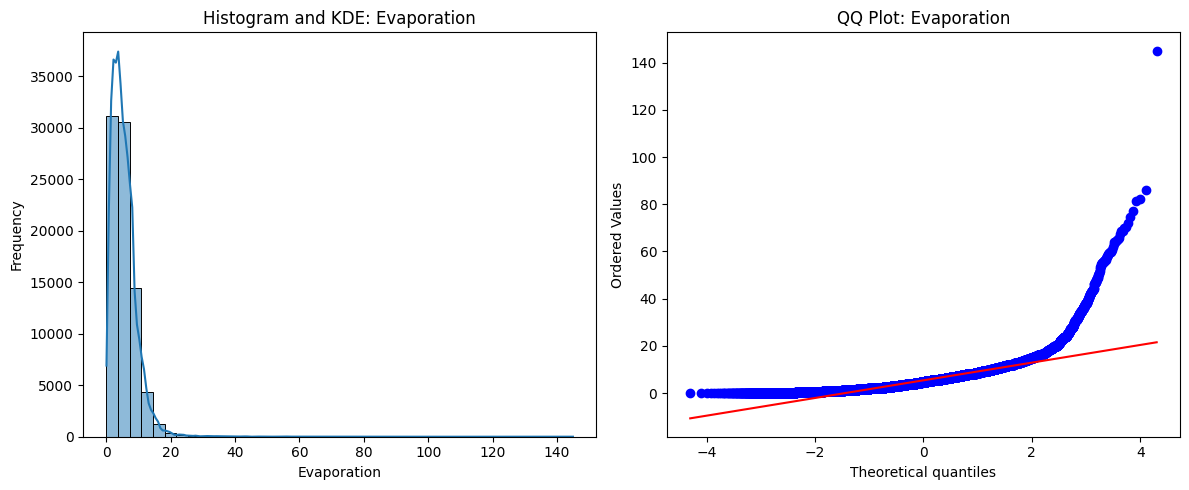

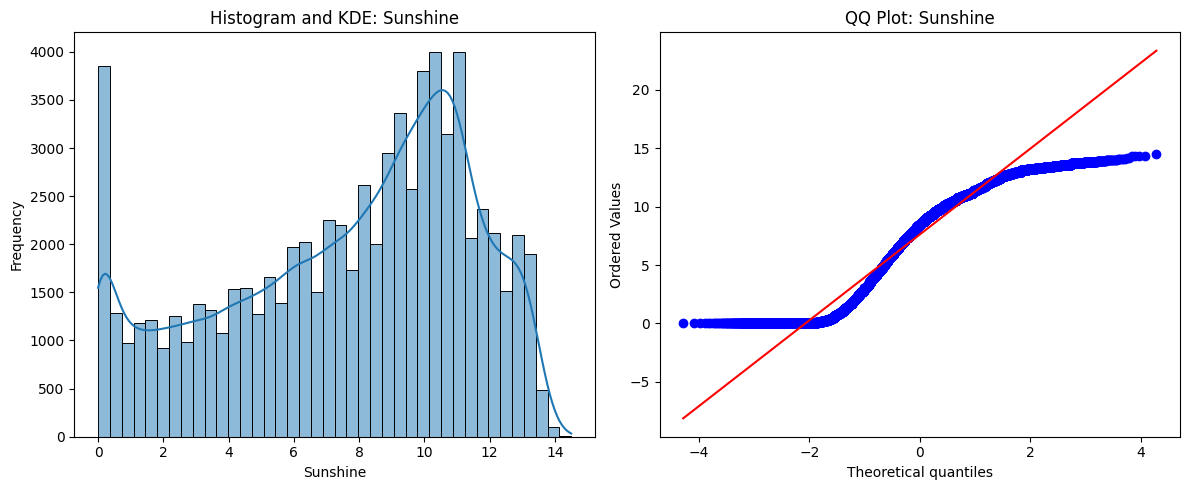

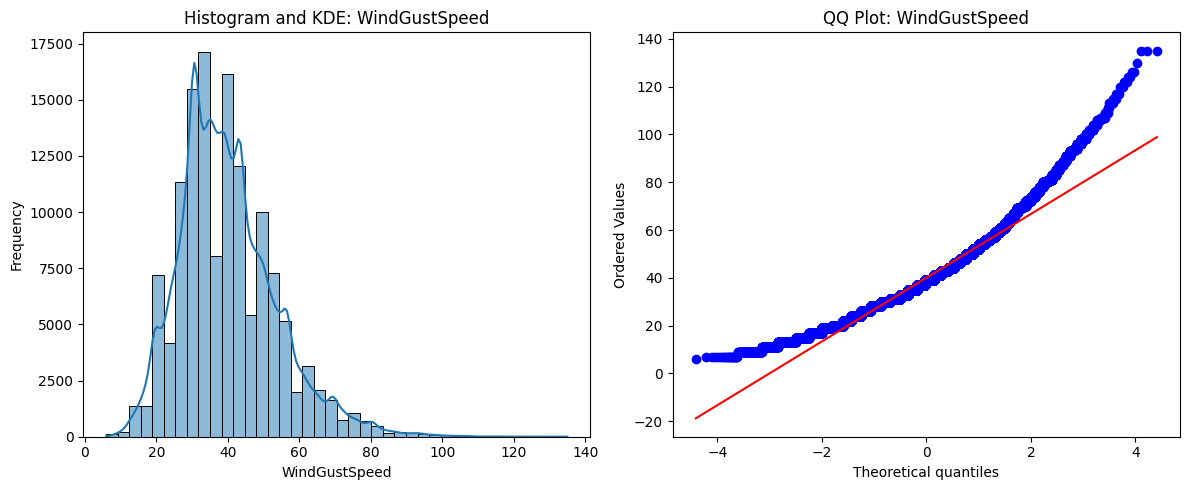

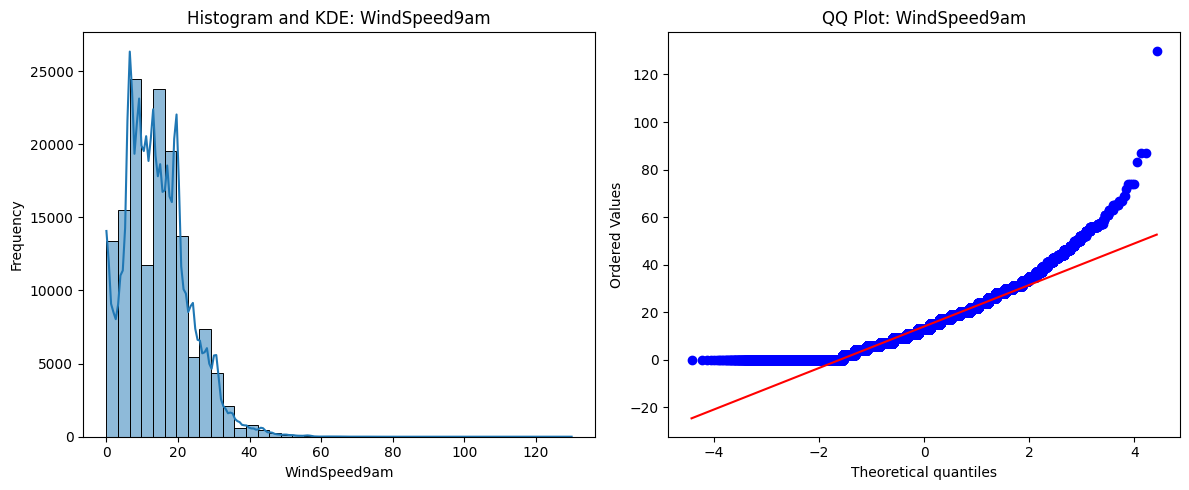

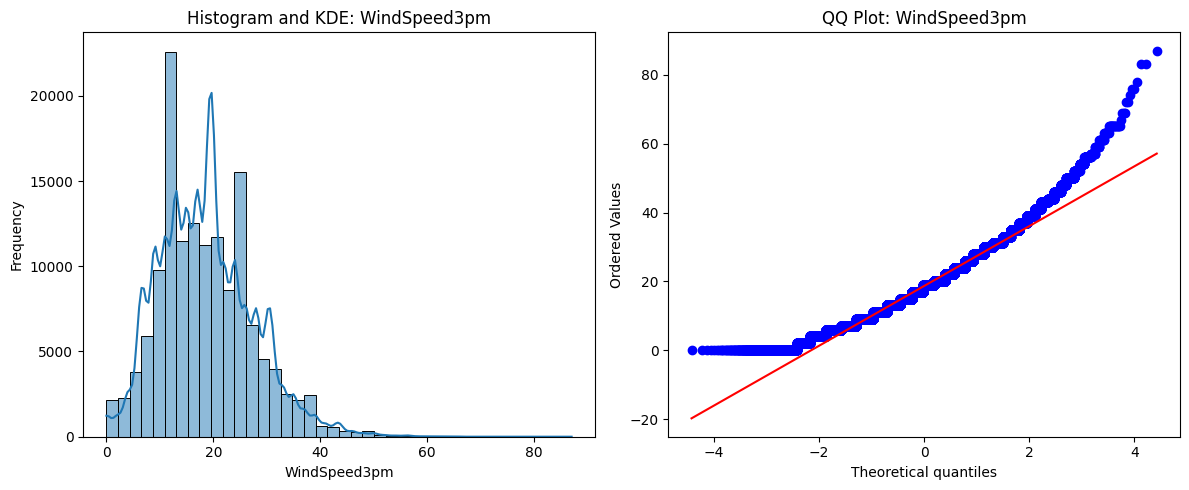

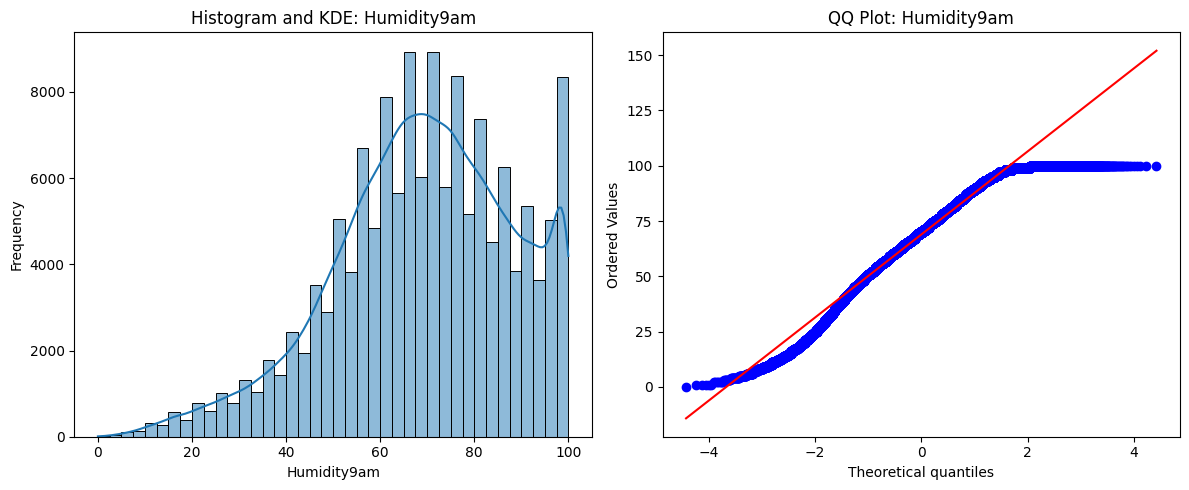

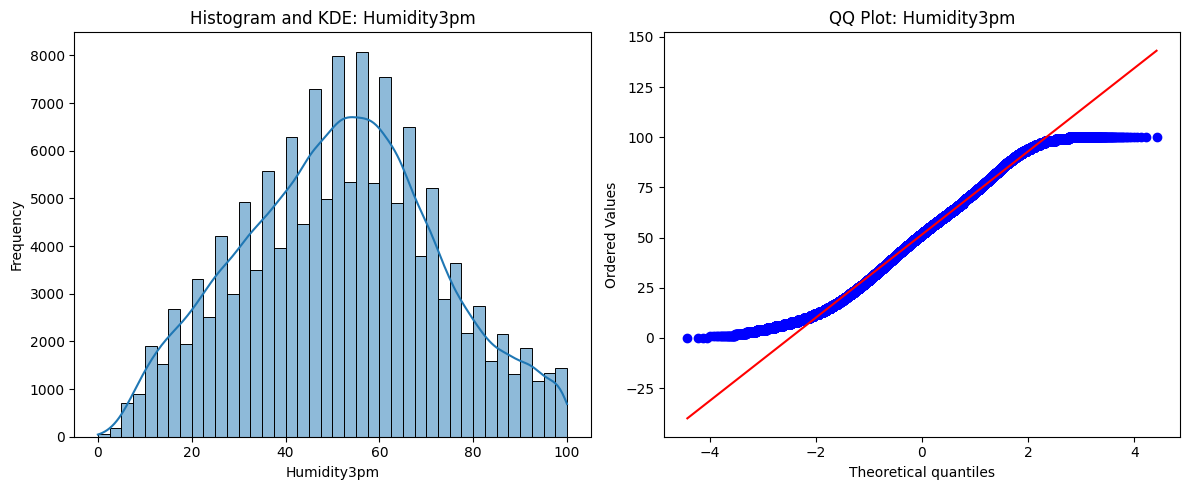

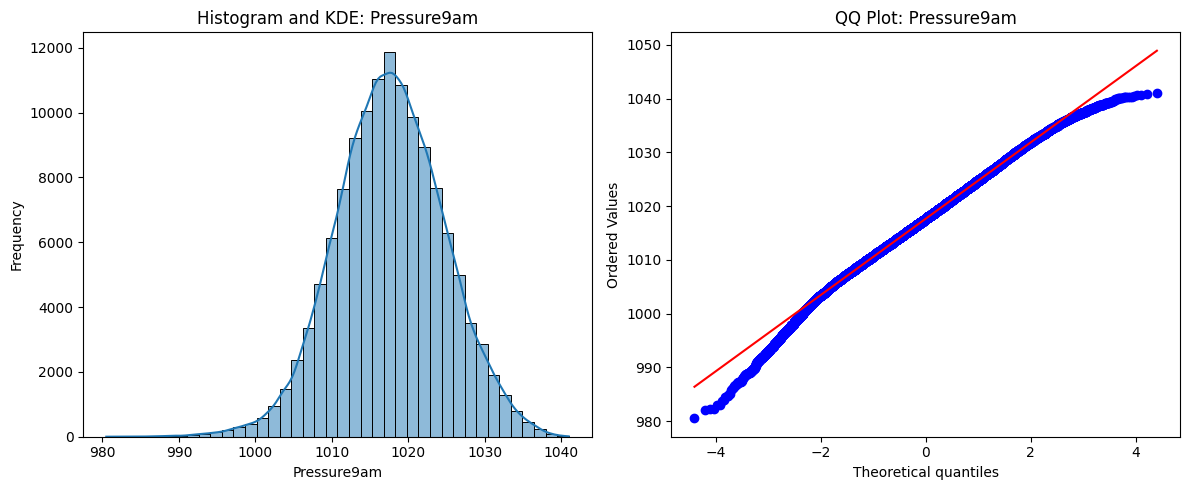

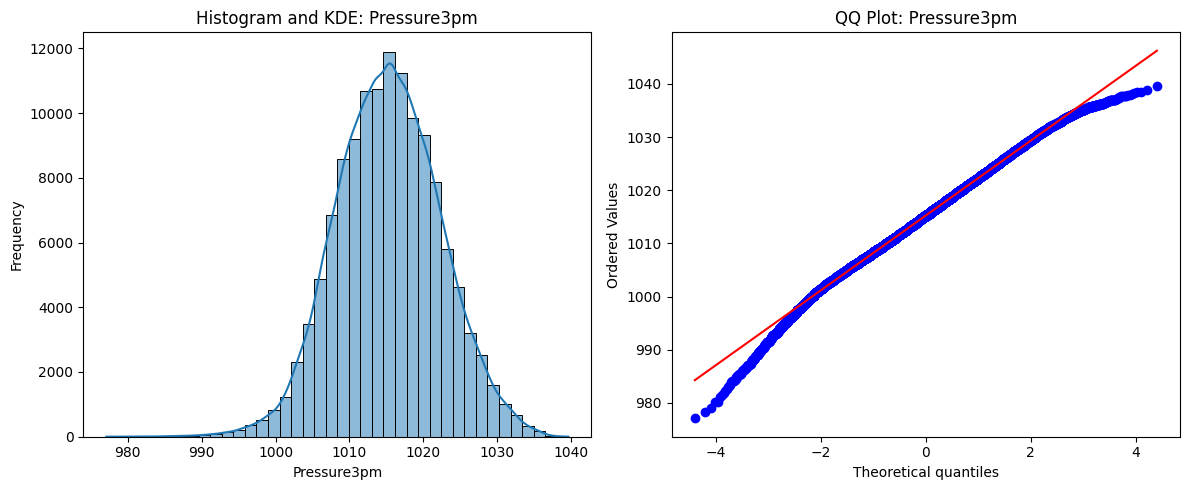

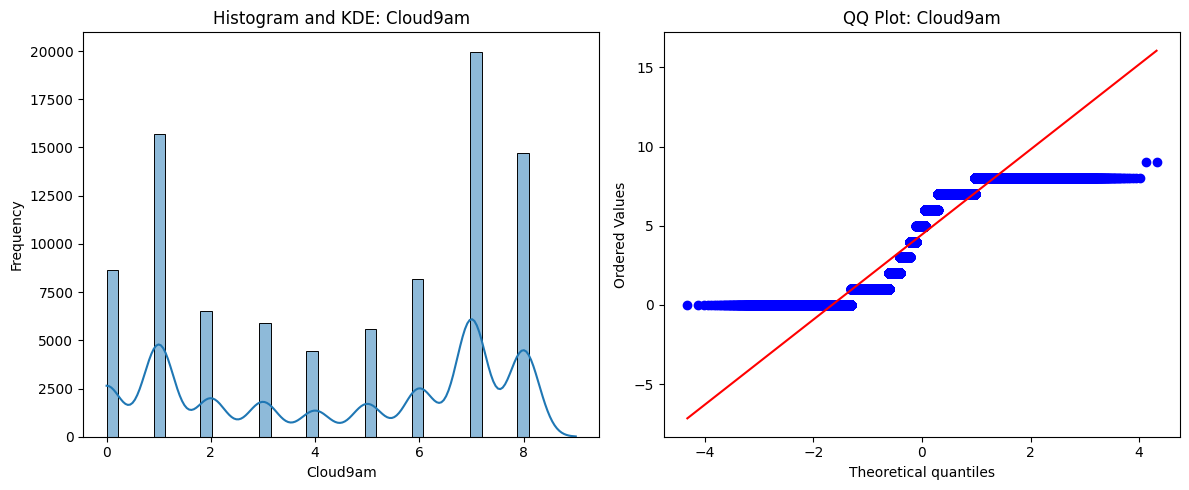

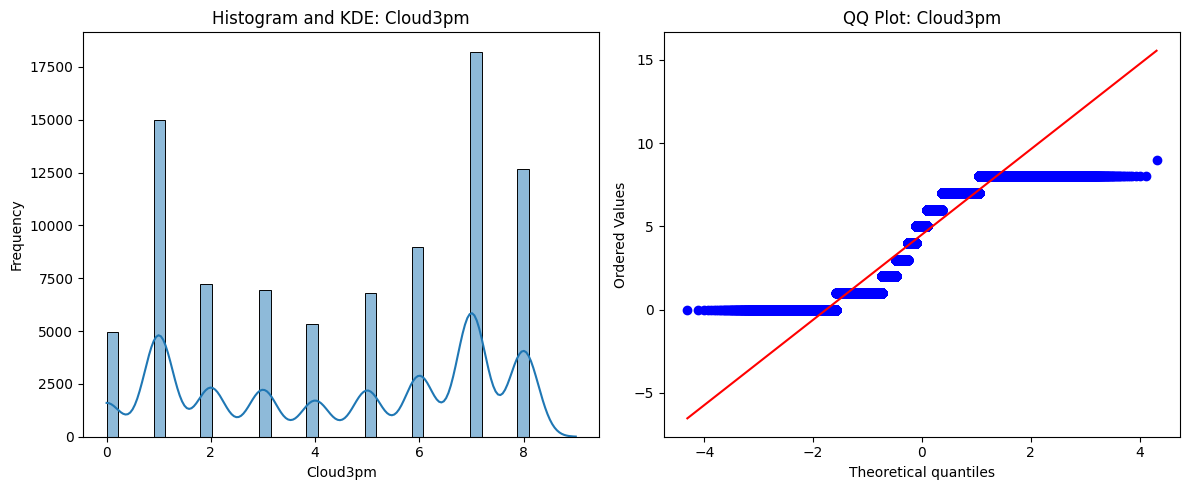

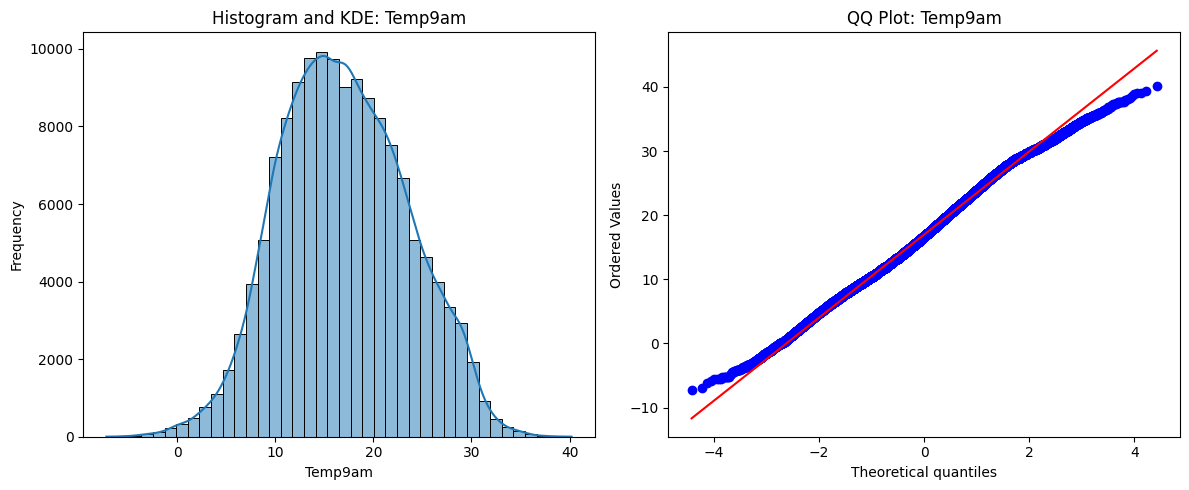

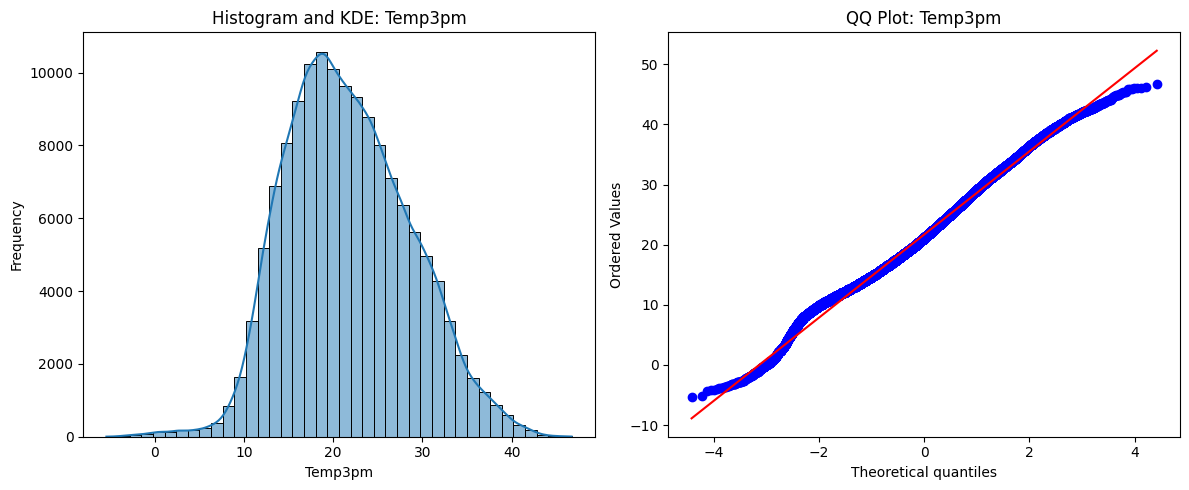

In [ ]:



continuous_cols = df.select_dtypes(include=['float64', 'int']).columns


def plot_histogram_qq(data, feature_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))


    sns.histplot(data[feature_name].dropna(), kde=True, bins=40, ax=axes[0])
    axes[0].set_title(f"Histogram and KDE: {feature_name}")
    axes[0].set_xlabel(feature_name)
    axes[0].set_ylabel("Frequency")


    stats.probplot(data[feature_name].dropna(), dist="norm", plot=axes[1])
    axes[1].get_lines()[1].set_color('red')
    axes[1].set_title(f"QQ Plot: {feature_name}")

    plt.tight_layout()
    plt.show()

for col in continuous_cols:
    plot_histogram_qq(df, col)


After observing many large numbers and different types of sparsity, we now focus on the more limited nominal data. This part is simpler.  

We will use bar plots here because our data is not continuous—it is sparse.  

The most important point to notice here is the imbalance in the `RainTomorrow` and `RainToday` data.

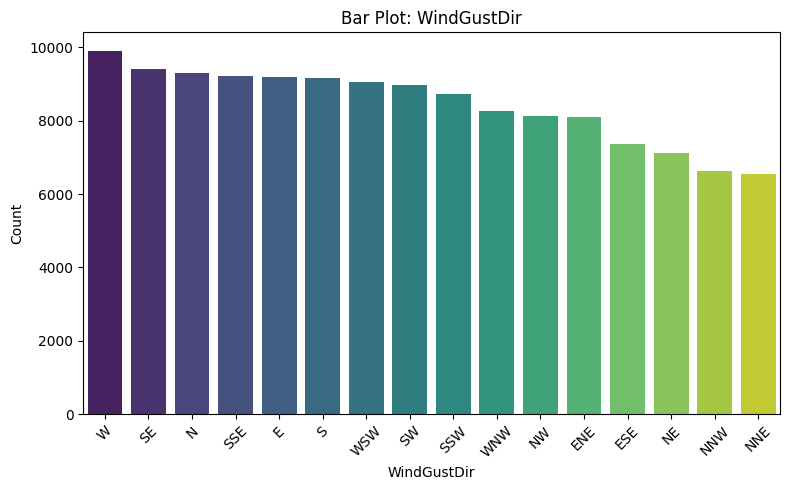

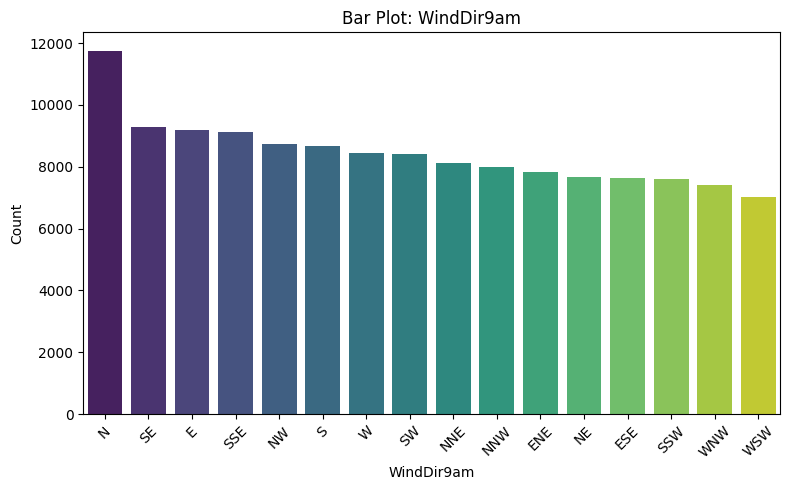

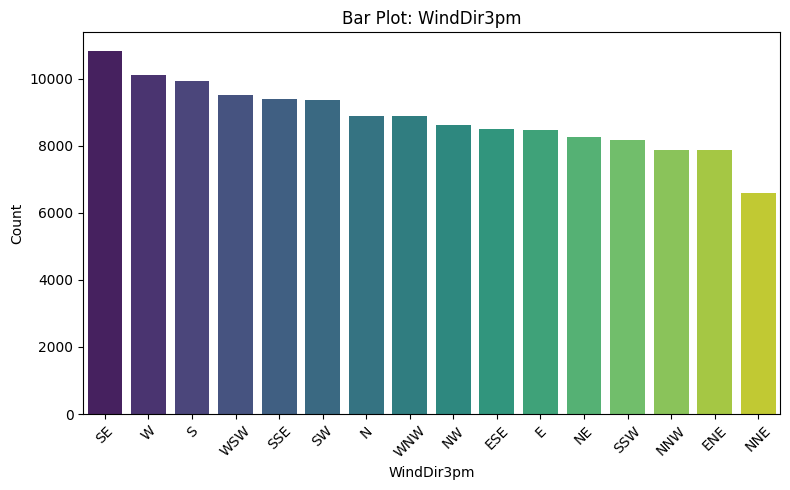

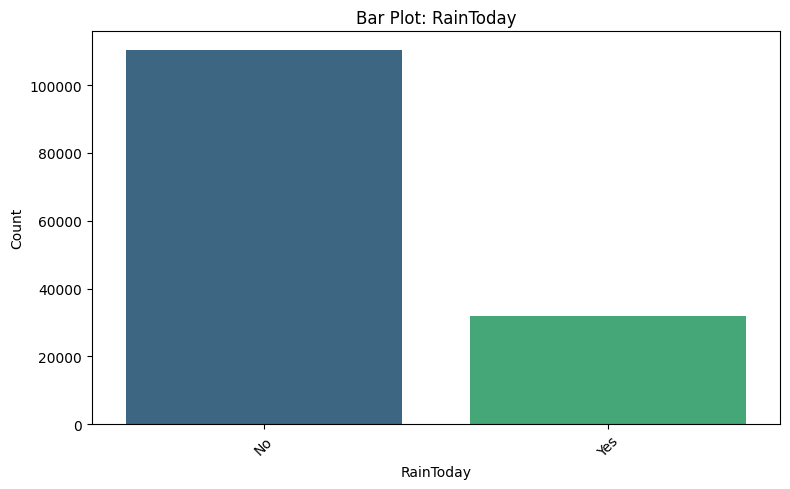

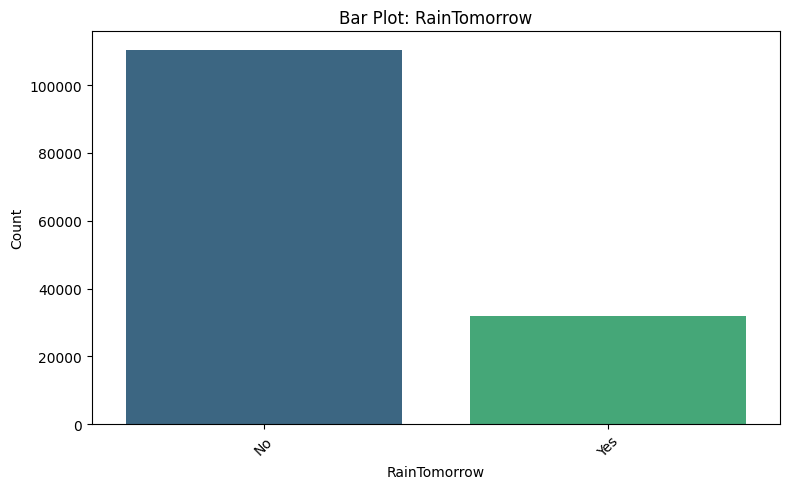

In [ ]:


excluded_cols = ['Date', 'Location']
categorical_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns if col not in excluded_cols]

def plot_bar(data, feature_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=data,
        x=feature_name,
        order=data[feature_name].value_counts().index,
        palette='viridis'
    )
    plt.title(f"Bar Plot: {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


for col in categorical_cols:
    plot_bar(df, col)


Here, we will examine the correlation between features to see how they affect each other—whether the relationship is positive, negative, or has no effect.

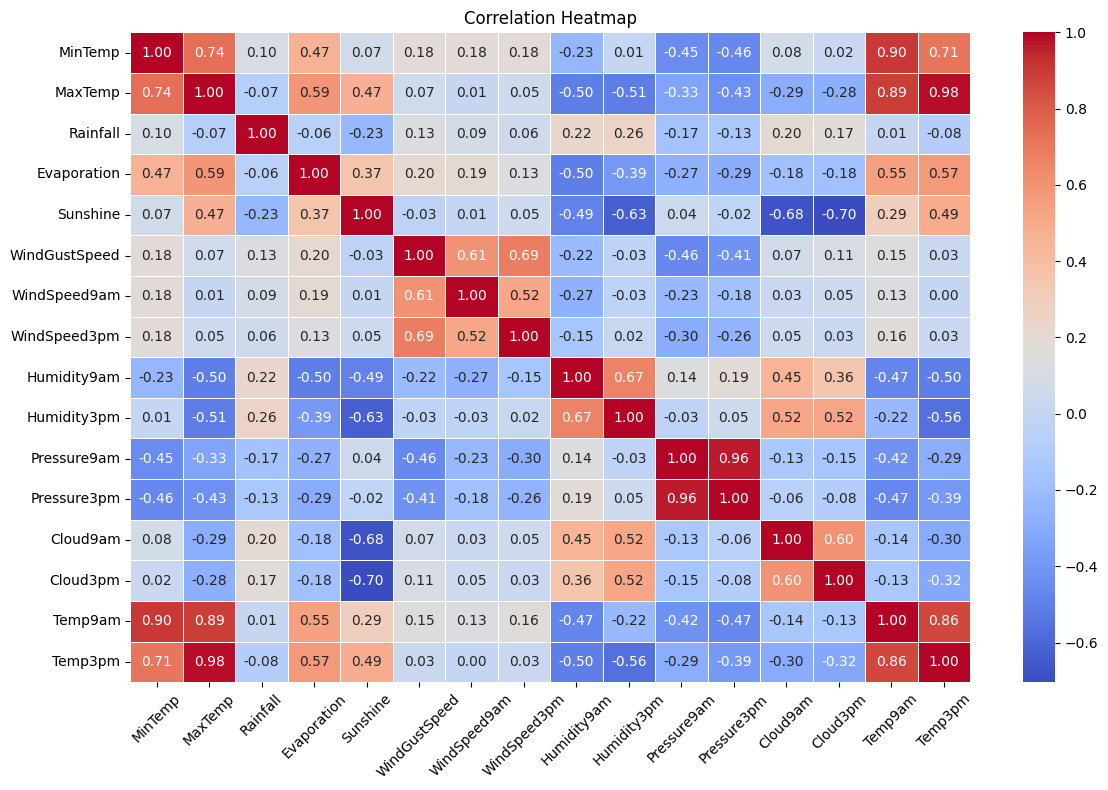

In [ ]:

correlation_matrix = df.select_dtypes(include=['float64', 'int']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True
)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Our target value is determining whether it will rain tomorrow or not.  

Because of this, we want to understand how other data affects this outcome.  

If your target is binary or has small numbers (like 4 or 5 categories), visually proportional bar plots are a good choice for understanding percentages across all data. (In our dataset, this might not represent real life accurately due to unbalanced data—I couldn’t decide.)

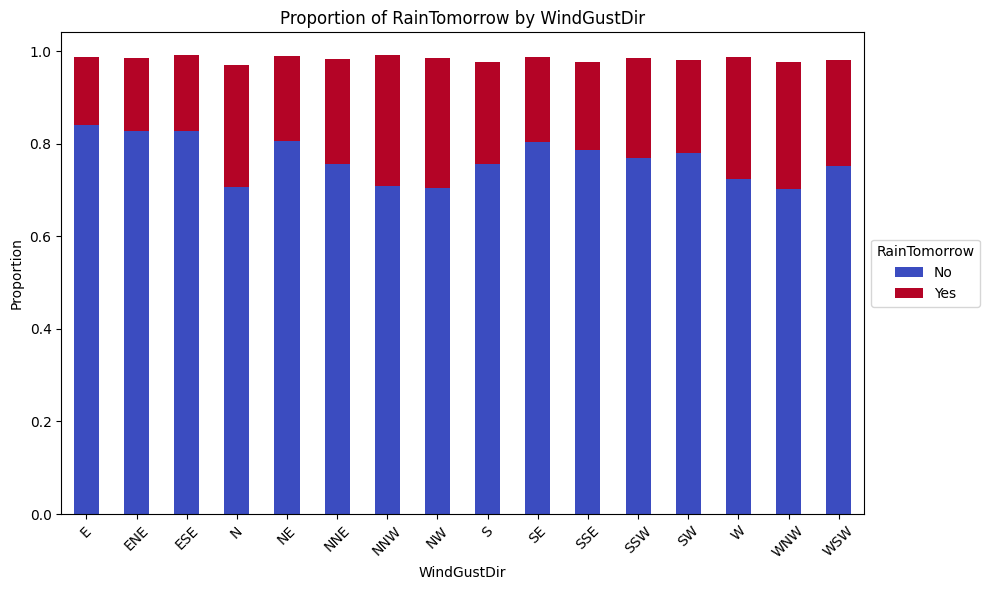

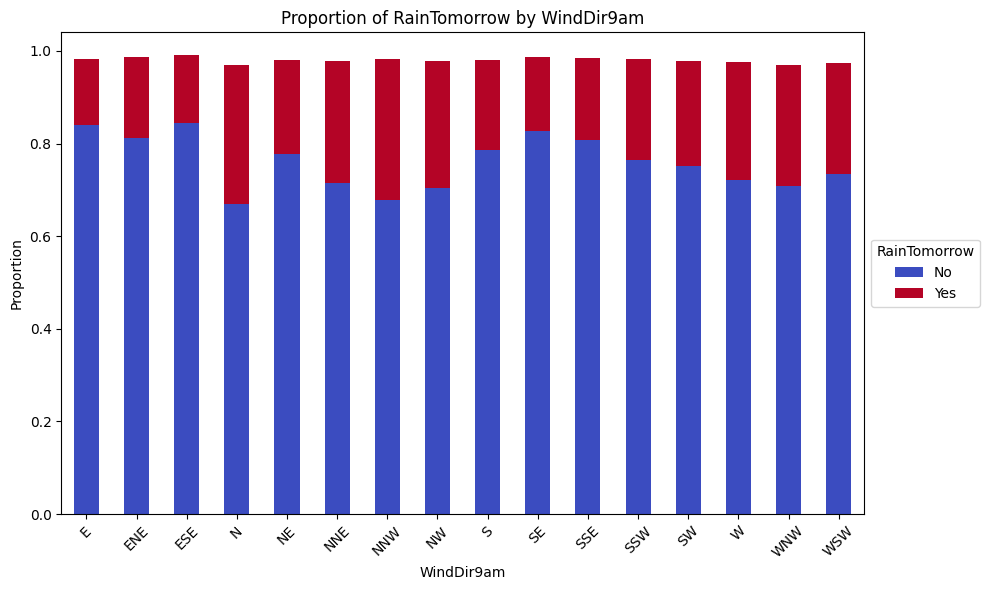

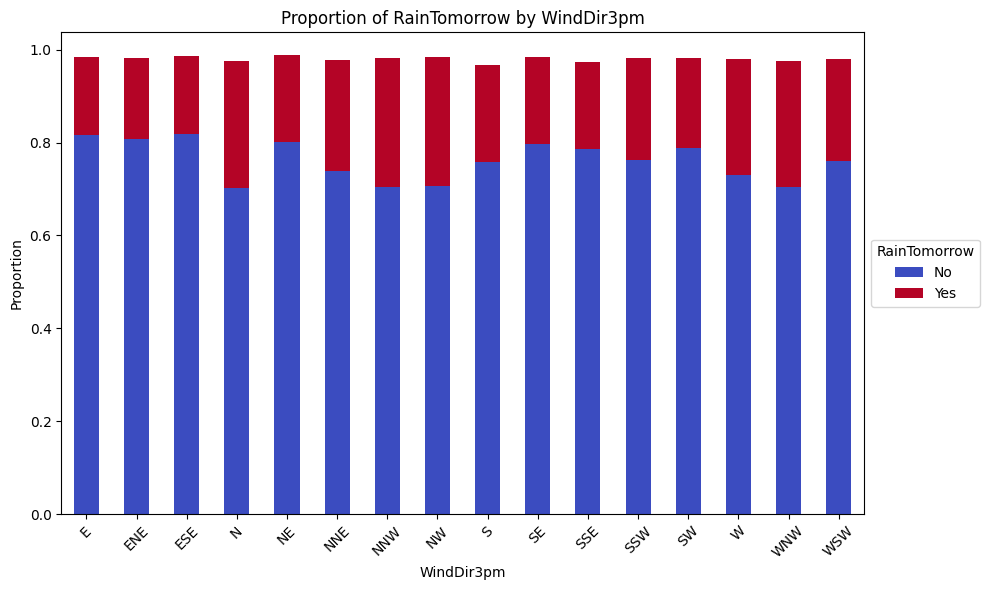

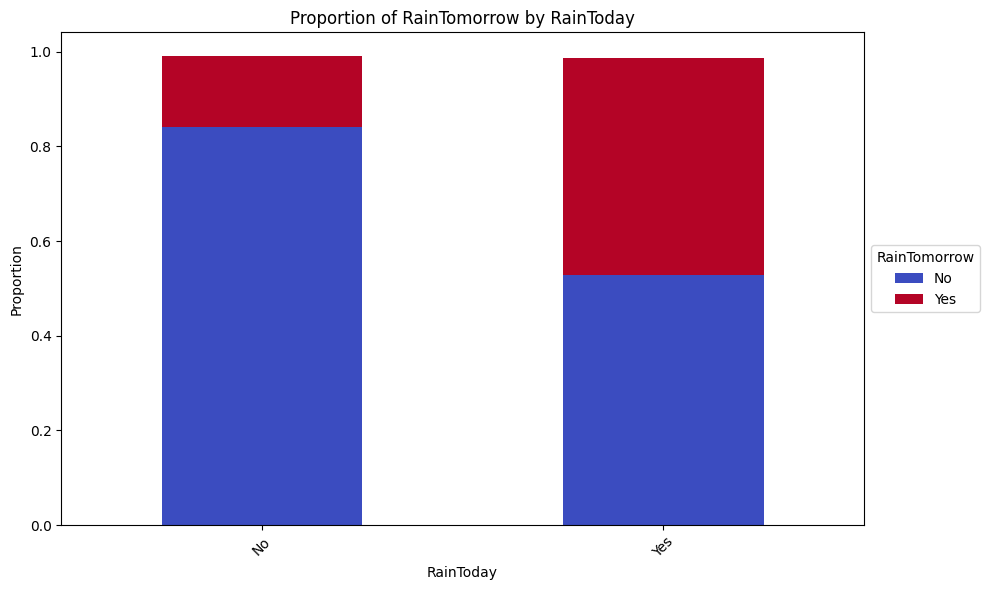

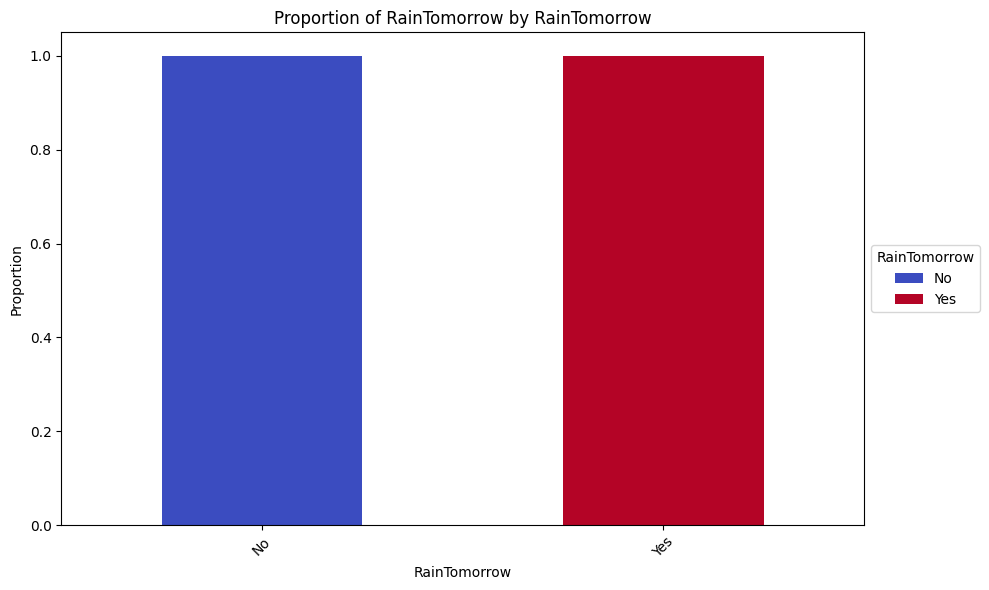

In [ ]:

def plot_proportional_bar(data, feature_name, target):

    proportion_df = (
        data.groupby([feature_name, target]).size() / data.groupby([feature_name]).size()
    ).unstack()


    proportion_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
    plt.title(f"Proportion of {target} by {feature_name}")
    plt.ylabel("Proportion")
    plt.xlabel(feature_name)
    plt.xticks(rotation=45)
    plt.legend(title=target, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


for col in categorical_cols:
    plot_proportional_bar(df, col, 'RainTomorrow')


Here, we will examine the unique values of our features. Even if they are continuous in real life, they can be categorized into a smaller set of values (since continuous values can take infinite possibilities between two points).

In [ ]:

for var in df:

    print(var, ' contains ', len(df[var].unique()), ' labels')

Date  contains  3436  labels
Location  contains  49  labels
MinTemp  contains  390  labels
MaxTemp  contains  506  labels
Rainfall  contains  682  labels
Evaporation  contains  359  labels
Sunshine  contains  146  labels
WindGustDir  contains  17  labels
WindGustSpeed  contains  68  labels
WindDir9am  contains  17  labels
WindDir3pm  contains  17  labels
WindSpeed9am  contains  44  labels
WindSpeed3pm  contains  45  labels
Humidity9am  contains  102  labels
Humidity3pm  contains  102  labels
Pressure9am  contains  547  labels
Pressure3pm  contains  550  labels
Cloud9am  contains  11  labels
Cloud3pm  contains  11  labels
Temp9am  contains  442  labels
Temp3pm  contains  503  labels
RainToday  contains  3  labels
RainTomorrow  contains  3  labels


We will examine the proportion of missing values. For some features, the missing values make up a significant portion. If these features are not crucial for our data, dropping them is a better option.  

I will drop some of them.

In [ ]:
(df.isna().sum().sort_values(ascending = False)) / len(df)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
WindSpeed9am     0.012148
Temp9am          0.012148
MinTemp          0.010209
MaxTemp          0.008669
Date             0.000000
Location         0.000000
dtype: float64

In [ ]:
df_cat = df.select_dtypes(include = ['object'])
(df_cat.isna().sum().sort_values(ascending = False)) / len(df)

WindDir9am      0.072639
WindGustDir     0.070989
WindDir3pm      0.029066
RainTomorrow    0.022460
RainToday       0.022419
Location        0.000000
Date            0.000000
dtype: float64

In [ ]:
df.drop(columns=['Sunshine', 'Evaporation', 'Cloud9am','Cloud3pm'], inplace=True)


We dropped data with a large proportion of missing values. However, if the data is crucial, we can impute it using more advanced methods like KNN imputer (a machine learning method for predicting missing values instead of classical statistical methods).  

Classical methods are generally simpler and often sufficient. But if you need more advanced techniques, the KNN imputer can be helpful.Remember, KNN is computationally much more expensive.

'''from sklearn.impute import KNNImputer


imputer = KNNImputer(n_neighbors=5)


df['Cloud3pm'] = imputer.fit_transform(df[['Cloud3pm']])
'''

In [ ]:
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [ ]:
df_num = df.select_dtypes(include = ['float64', 'int64'])

(df_num.isna().sum().sort_values(ascending = False)) / len(df)

Pressure9am      0.103568
Pressure3pm      0.103314
WindGustSpeed    0.070555
Humidity3pm      0.030984
Temp3pm          0.024811
Rainfall         0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
WindSpeed9am     0.012148
Temp9am          0.012148
MinTemp          0.010209
MaxTemp          0.008669
dtype: float64

The process is the same as for categorical data, except instead of using the mode, we use the median.  

This is because we don’t want to alter the characteristic of our data and prefer to preserve its central tendency. Additionally, our data contains outliers.  

Outliers are anomalies in the data—some might arise from poor data collection, survey issues, or the nature of electrical sensors that occasionally peak up or down. These outliers are not part of the original nature of the data, so we don’t want to deal with them in this step.

In [ ]:
continuous_cols = [
    'MinTemp', 'MaxTemp', 'Rainfall',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
    'Humidity3pm', 'Pressure9am', 'Pressure3pm',
     'Temp9am', 'Temp3pm'
]
for col in continuous_cols:
    df[col] = df[col].fillna(df[col].median())


We added year and month data to capture seasonal or yearly trends in our data.  

The same season in different years might not make sense to the algorithm. However, by including this information, it becomes meaningful.

In [ ]:

df['Date'] = pd.to_datetime(df['Date'])


df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

df.head()


Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0 2008-12-01   Albury     13.4     22.9       0.6           W           44.0   
1 2008-12-02   Albury      7.4     25.1       0.0         WNW           44.0   
2 2008-12-03   Albury     12.9     25.7       0.0         WSW           46.0   
3 2008-12-04   Albury      9.2     28.0       0.0          NE           24.0   
4 2008-12-05   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm RainToday RainTomorrow  Year  \
0       1007.7       1007.1     16.9     21.8        No           No  2008   
1       1010.6       1007.8     17.2     24.3        No           No  2008   
2       1007.6       1008.7     21.0     23.2        No           No  2008   
3       1017.6       1012.8     18.1     26.5        No           No  2008   
4       1010.8       1006.0     17.8     29.7        No           No  2008   

   Month  
0     12  
1     12  
2     12  
3     12  
4     12

In [ ]:
(df.isnull().sum()/len(df))*100

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
Year             0.0
Month            0.0
dtype: float64

In [ ]:


url = "https://cdn.prod.website-files.com/601ca16f9dfe00cc7bb4027c/638520ee036310b8c58fa620_seasonality_blog_imgs_beige.003.jpeg"

display.Image(url=url)


We added `year` and `month` data to capture seasonal or yearly trends in our dataset.  

The same season but in different years might not make sense for the algorithm. However, by adding these features, it becomes meaningful.  

Additionally, we included the range of some values (e.g., HPA changes) as they might indicate rain prediction. (Although I don’t have domain knowledge, changes in HPA often signal weather events.)

In [ ]:
def create_features(df):
    df = df.copy()


    df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)


    df['Season'] = pd.cut(df['Month'],
                         bins=[0, 3, 6, 9, 12],
                         labels=['Summer', 'Autumn', 'Winter', 'Spring'])

    df['Temp_Range'] = df['MaxTemp'] - df['MinTemp']


    df['Humidity_Range'] = df['Humidity9am'] - df['Humidity3pm']


    df['Pressure_Range'] = df['Pressure9am'] - df['Pressure3pm']

    return df
df = create_features(df)

Here, we will decode our data because values like "blue eye" or "brown eye" are meaningless mathematically to algorithms. However, converting them to `1` or `0` makes them understandable.  

But now we face another problem: Is `1` greater than `0`? Is "blue" greater than "brown"? Of course not. To avoid this issue, we use the one-hot encoding method for nominal categories.  

If you have domain knowledge, features like wind direction might be considered ordinal. However, for simplicity, treating it as nominal is a better choice in this case.

In [ ]:


def encode_categorical_variables(df):

    df = df.copy()

    target = 'RainTomorrow'

    categorical_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
                         'RainToday', 'Season']


    rain_today_map = {'No': 0, 'Yes': 1}
    df['RainToday'] = df['RainToday'].map(rain_today_map)

    df_encoded = pd.get_dummies(df,
                              columns=categorical_columns,
                              prefix=categorical_columns,
                              prefix_sep='_',
                              dtype=int)

    le = LabelEncoder()
    df_encoded[target] = le.fit_transform(df[target])


    cols = list(df_encoded.columns)
    cols.remove(target)
    cols.sort()
    cols.append(target)
    df_encoded = df_encoded[cols]

    return df_encoded, le



In [ ]:
df_encoded, label_encoder = encode_categorical_variables(df)

After encoding, our feature columns increased from 27 to 124.  

However, this also reduced the data type complexity.

In [ ]:
print(f"Original shape: {df.shape}")
print(f"Encoded shape: {df_encoded.shape}")

Original shape: (145460, 27)
Encoded shape: (145460, 124)


In [ ]:
df_encoded

Date  Humidity3pm  Humidity9am  Humidity_Range  \
0      2008-12-01         22.0         71.0            49.0   
1      2008-12-02         25.0         44.0            19.0   
2      2008-12-03         30.0         38.0             8.0   
3      2008-12-04         16.0         45.0            29.0   
4      2008-12-05         33.0         82.0            49.0   
...           ...          ...          ...             ...   
145455 2017-06-21         24.0         51.0            27.0   
145456 2017-06-22         21.0         56.0            35.0   
145457 2017-06-23         24.0         53.0            29.0   
145458 2017-06-24         24.0         51.0            27.0   
145459 2017-06-25         36.0         62.0            26.0   

        Location_Adelaide  Location_Albany  Location_Albury  \
0                       0                0                1   
1                       0                0                1   
2                       0                0                1   
3                       0                0                1   
4                       0                0                1   
...                   ...              ...              ...   
145455                  0                0                0   
145456                  0                0                0   
145457                  0                0                0   
145458                  0                0                0   
145459                  0                0                0   

        Location_AliceSprings  Location_BadgerysCreek  Location_Ballarat  \
0                           0                       0                  0   
1                           0                       0                  0   
2                           0                       0                  0   
3                           0                       0                  0   
4                           0                       0                  0   
...                       ...                     ...                ...   
145455                      0                       0                  0   
145456                      0                       0                  0   
145457                      0                       0                  0   
145458                      0                       0                  0   
145459                      0                       0                  0   

        Location_Bendigo  Location_Brisbane  Location_Cairns  \
0                      0                  0                0   
1                      0                  0                0   
2                      0                  0                0   
3                      0                  0                0   
4                      0                  0                0   
...                  ...                ...              ...   
145455                 0                  0                0   
145456                 0                  0                0   
145457                 0                  0                0   
145458                 0                  0                0   
145459                 0                  0                0   

        Location_Canberra  Location_Cobar  Location_CoffsHarbour  \
0                       0               0                      0   
1                       0               0                      0   
2                       0               0                      0   
3                       0               0                      0   
4                       0               0                      0   
...                   ...             ...                    ...   
145455                  0               0                      0   
145456                  0               0                      0   
145457                  0               0                      0   
145458                  0               0                      0   
145459                  0               0                      0   



We dropped the `Date` and `Month` values because we added their cyclical representations for better representation.  

This helps avoid adding unnecessary noise to the data.

In [ ]:
df_encoded = df_encoded.drop(columns=['Date'])

In [ ]:
df_encoded = df_encoded.drop(columns=['Month'])

In [ ]:
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
                        'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                        'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm',
                        'Month_sin', 'Month_cos', 'Temp_Range', 'Humidity_Range',
                        'Pressure_Range']

In [ ]:
df_encoded

Humidity3pm  Humidity9am  Humidity_Range  Location_Adelaide  \
0              22.0         71.0            49.0                  0   
1              25.0         44.0            19.0                  0   
2              30.0         38.0             8.0                  0   
3              16.0         45.0            29.0                  0   
4              33.0         82.0            49.0                  0   
...             ...          ...             ...                ...   
145455         24.0         51.0            27.0                  0   
145456         21.0         56.0            35.0                  0   
145457         24.0         53.0            29.0                  0   
145458         24.0         51.0            27.0                  0   
145459         36.0         62.0            26.0                  0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
0                     0                1                      0   
1                     0                1                      0   
2                     0                1                      0   
3                     0                1                      0   
4                     0                1                      0   
...                 ...              ...                    ...   
145455                0                0                      0   
145456                0                0                      0   
145457                0                0                      0   
145458                0                0                      0   
145459                0                0                      0   

        Location_BadgerysCreek  Location_Ballarat  Location_Bendigo  \
0                            0                  0                 0   
1                            0                  0                 0   
2                            0                  0                 0   
3                            0                  0                 0   
4                            0                  0                 0   
...                        ...                ...               ...   
145455                       0                  0                 0   
145456                       0                  0                 0   
145457                       0                  0                 0   
145458                       0                  0                 0   
145459                       0                  0                 0   

        Location_Brisbane  Location_Cairns  Location_Canberra  Location_Cobar  \
0                       0                0                  0               0   
1                       0                0                  0               0   
2                       0                0                  0               0   
3                       0                0                  0               0   
4                       0                0                  0               0   
...                   ...              ...                ...             ...   
145455                  0                0                  0               0   
145456                  0                0                  0               0   
145457                  0                0                  0               0   
145458                  0                0                  0               0   
145459                  0                0                  0               0   

        Location_CoffsHarbour  Location_Dartmoor  Location_Darwin  \
0                           0                  0                0   
1                           0                  0                0   
2                           0                  0                0   
3                           0                  0                0   
4                           0                  0                0   
...                       ...                ...              ...   
145455                      0            

For example, some categories have values like `0, 1, 2`, while others have extremely large numbers like `1e+9`. For algorithms, this is computationally inefficient. We aim to understand trends or categories, not exact numerical values, as in linear regression. Therefore, we need to scale the values to bring them to a comparable range.  

As mentioned earlier, we don’t want to remove outliers completely because they can represent important trends. Instead, we choose a scaling method that accommodates these outliers.  

There are many scaling methods, but since our dataset has outliers, I prefer using the **RobustScaler**.

In [ ]:


def apply_robust_scaling(df):

    df = df.copy()


    scaler = RobustScaler()

    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df, scaler



The scaler value is important because, if we want to revert to the original data, it will be necessary.

In [ ]:
df_scaled, scaler = apply_robust_scaling(df_encoded)

In [ ]:
df_scaled

Humidity3pm  Humidity9am  Humidity_Range  Location_Adelaide  \
0         -1.071429     0.038462        1.454545                  0   
1         -0.964286    -1.000000        0.090909                  0   
2         -0.785714    -1.230769       -0.409091                  0   
3         -1.285714    -0.961538        0.545455                  0   
4         -0.678571     0.461538        1.454545                  0   
...             ...          ...             ...                ...   
145455    -1.000000    -0.730769        0.454545                  0   
145456    -1.107143    -0.538462        0.818182                  0   
145457    -1.000000    -0.653846        0.545455                  0   
145458    -1.000000    -0.730769        0.454545                  0   
145459    -0.571429    -0.307692        0.409091                  0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
0                     0                1                      0   
1                     0                1                      0   
2                     0                1                      0   
3                     0                1                      0   
4                     0                1                      0   
...                 ...              ...                    ...   
145455                0                0                      0   
145456                0                0                      0   
145457                0                0                      0   
145458                0                0                      0   
145459                0                0                      0   

        Location_BadgerysCreek  Location_Ballarat  Location_Bendigo  \
0                            0                  0                 0   
1                            0                  0                 0   
2                            0                  0                 0   
3                            0                  0                 0   
4                            0                  0                 0   
...                        ...                ...               ...   
145455                       0                  0                 0   
145456                       0                  0                 0   
145457                       0                  0                 0   
145458                       0                  0                 0   
145459                       0                  0                 0   

        Location_Brisbane  Location_Cairns  Location_Canberra  Location_Cobar  \
0                       0                0                  0               0   
1                       0                0                  0               0   
2                       0                0                  0               0   
3                       0                0                  0               0   
4                       0                0                  0               0   
...                   ...              ...                ...             ...   
145455                  0                0                  0               0   
145456                  0                0                  0               0   
145457                  0                0                  0               0   
145458                  0                0                  0               0   
145459                  0                0                  0               0   

        Location_CoffsHarbour  Location_Dartmoor  Location_Darwin  \
0                           0                  0                0   
1                           0                  0                0   
2                           0                  0                0   
3                           0                  0                0   
4                           0                  0                0   
...                       ...                ...              ...   
145455                      0            

In [ ]:
df_scaled[numerical_columns].describe()

MinTemp        MaxTemp       Rainfall  WindGustSpeed  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean        0.021105       0.060388       3.846650       0.064146   
std         0.699536       0.694937      13.982952       0.874729   
min        -2.252747      -2.686275       0.000000      -2.200000   
25%        -0.472527      -0.450980       0.000000      -0.533333   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.527473       0.549020       1.000000       0.466667   
max         2.406593       2.500000     618.333333       6.400000   

        WindSpeed9am   WindSpeed3pm    Humidity9am    Humidity3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean        0.085896      -0.030022      -0.042260      -0.015950   
std         0.738483       0.792429       0.725206       0.731119   
min        -1.083333      -1.727273      -2.692308      -1.857143   
25%        -0.500000      -0.545455      -0.500000      -0.535714   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.500000       0.454545       0.500000       0.464286   
max         9.750000       6.181818       1.153846       1.714286   

         Pressure9am    Pressure3pm        Temp9am        Temp3pm  \
count  145460.000000  145460.000000  145460.000000  145460.000000   
mean        0.005394       0.006038       0.031207       0.059886   
std         0.810661       0.802891       0.701011       0.721122   
min        -4.469880      -4.590361      -2.597826      -2.789474   
25%        -0.493976      -0.493976      -0.478261      -0.463158   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.506024       0.506024       0.521739       0.536842   
max         2.819277       2.939759       2.554348       2.694737   

           Month_sin      Month_cos     Temp_Range  Humidity_Range  \
count  145460.000000  145460.000000  145460.000000   145460.000000   
mean        0.011584      -0.011973       0.072765        0.015812   
std         0.705267       0.518778       0.688663        0.740834   
min        -1.000000      -0.732051      -3.500000       -4.909091   
25%        -0.500000      -0.633975      -0.458333       -0.500000   
50%         0.000000       0.000000       0.000000        0.000000   
75%         0.500000       0.366025       0.541667        0.500000   
max         1.000000       0.732051       2.902778        3.363636   

       Pressure_Range  
count   145460.000000  
mean        -0.002674  
std          0.951512  
min        -11.350000  
25%         -0.450000  
50%          0.000000  
75%          0.550000  
max         12.050000

In [ ]:



X = df_scaled.drop(columns=['RainTomorrow'])
y = df_scaled['RainTomorrow']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 116368 samples
Test set size: 29092 samples


Why did I choose recall?  

In this scenario, we assume we are trying to predict whether it will rain today for human daily activities. If we predict rain and it doesn’t rain, it’s not too bad. However, if we predict no rain and it rains, that’s terrible. Therefore, **false negatives** are more critical in this case.  

But this depends on specific scenarios:  
- For a farmer, **false positives** might be more important. If you predict rain but there’s no rain, it’s bad for the crops.  

Why did I choose F1, Fβ, and F2?  
- F2 values give more weight to recall, which is crucial in scenarios where false negatives matter more.  
- F1 is useful for comparing performance when precision and recall are equally important or for reference against similar F2 values.  

Why ROC-AUC curve?  
- The ROC-AUC curve helps determine if the model is making statistically random predictions or if it can effectively distinguish between rain and no rain.  

I added the Brier score because it is a more general metric for evaluating models. As I read, it provides an overview of prediction quality, but I couldn’t fully figure it out yet.

In [ ]:
X = df_encoded.drop(columns='RainTomorrow')
y = df_encoded['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:


def evaluate_model(y_true, y_pred, y_prob):
    metrics = {
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'f2': fbeta_score(y_true, y_pred, beta=2),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'brier': brier_score_loss(y_true, y_prob),
    }
    return metrics

def plot_roc(y_true, y_prob, model_label='Model'):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{model_label} (AUC={auc:.3f})')


In [ ]:


dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:,1]
dt_metrics = evaluate_model(y_test, y_pred_dt, y_prob_dt)


In [ ]:
dt_metrics

{'recall': np.float64(0.5129283489096573),
 'f1': np.float64(0.5086107035292301),
 'f2': np.float64(0.5111925238287435),
 'roc_auc': np.float64(0.6850234215093974),
 'brier': np.float64(0.2187278766976794)}

In [ ]:


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
rf_metrics = evaluate_model(y_test, y_pred_rf, y_prob_rf)


In [ ]:
rf_metrics

{'recall': np.float64(0.46713395638629285),
 'f1': np.float64(0.5800212745382458),
 'f2': np.float64(0.5065707239620283),
 'roc_auc': np.float64(0.8793645654018736),
 'brier': np.float64(0.10667852402039948)}

In [ ]:


xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_prob_xgb)


In [ ]:
xgb_metrics

{'recall': np.float64(0.5409657320872274),
 'f1': np.float64(0.6263300270513976),
 'f2': np.float64(0.572158154859967),
 'roc_auc': np.float64(0.8877691093024841),
 'brier': np.float64(0.10234257922329208)}

In [ ]:


param_grid_dt = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10, 50]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

print("Best Decision Tree params:", grid_dt.best_params_)
y_pred_dt_best = best_dt.predict(X_test)
y_prob_dt_best = best_dt.predict_proba(X_test)[:,1]
dt_best_metrics = evaluate_model(y_test, y_pred_dt_best, y_prob_dt_best)
print("Tuned Decision Tree Metrics:", dt_best_metrics)


Best Decision Tree params: {'max_depth': 10, 'min_samples_split': 50}
Tuned Decision Tree Metrics: {'recall': np.float64(0.47149532710280373), 'f1': np.float64(0.5577667219458264), 'f2': np.float64(0.5025901574018729), 'roc_auc': np.float64(0.8379319248961761), 'brier': np.float64(0.12082687515535882)}


In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("Best RF params:", grid_rf.best_params_)
y_pred_rf_best = best_rf.predict(X_test)
y_prob_rf_best = best_rf.predict_proba(X_test)[:,1]
rf_best_metrics = evaluate_model(y_test, y_pred_rf_best, y_prob_rf_best)
print("Tuned Random Forest Metrics:", rf_best_metrics)


Best RF params: {'max_depth': None, 'n_estimators': 200}
Tuned Random Forest Metrics: {'recall': np.float64(0.4700934579439252), 'f1': np.float64(0.5826817260353316), 'f2': np.float64(0.5094702724602451), 'roc_auc': np.float64(0.881809056197882), 'brier': np.float64(0.10619275108604745)}


In [ ]:
param_grid_xgb = {
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}
grid_xgb = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

print("Best XGBoost params:", grid_xgb.best_params_)
y_pred_xgb_best = best_xgb.predict(X_test)
y_prob_xgb_best = best_xgb.predict_proba(X_test)[:,1]
xgb_best_metrics = evaluate_model(y_test, y_pred_xgb_best, y_prob_xgb_best)
print("Tuned XGBoost Metrics:", xgb_best_metrics)


Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Tuned XGBoost Metrics: {'recall': np.float64(0.5250778816199377), 'f1': np.float64(0.6190432467174731), 'f2': np.float64(0.5590196013399223), 'roc_auc': np.float64(0.8888158668548576), 'brier': np.float64(0.10209749240921852)}


Boosting models tend to perform well with fewer features, especially one or two. In contrast, Random Forest models have a more distributed feature importance due to the nature of bagging.

Feature Importances - Decision Tree


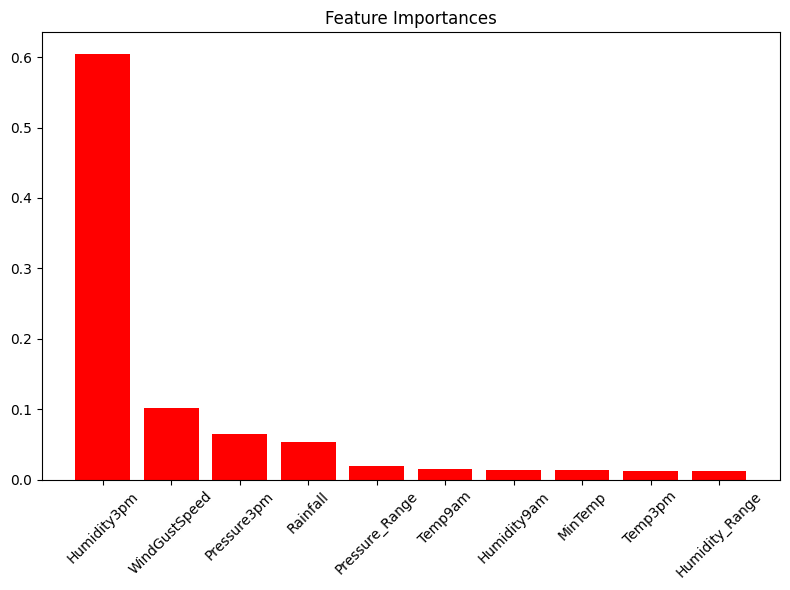

Feature Importances - Random Forest


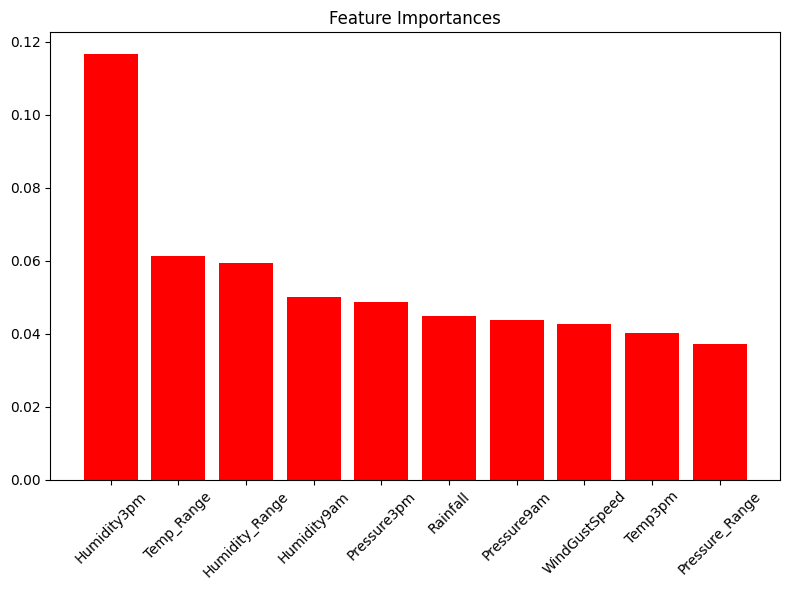

Feature Importances - XGBoost


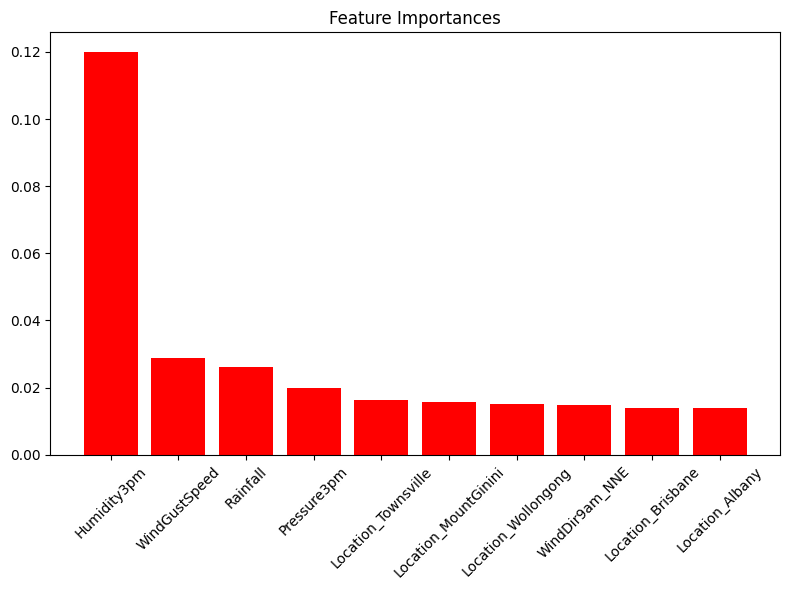

In [ ]:


def plot_feature_importance(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8,6))
    plt.title("Feature Importances")
    plt.bar(range(top_n), importances[indices], color="r", align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

feature_names = X_train.columns.tolist()

print("Feature Importances - Decision Tree")
plot_feature_importance(best_dt, feature_names)

print("Feature Importances - Random Forest")
plot_feature_importance(best_rf, feature_names)

print("Feature Importances - XGBoost")
plot_feature_importance(best_xgb, feature_names)


Now, we will train the models again to understand the effect of weighting, since we have an unbalanced dataset.

In [ ]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))


dt_weighted = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)
dt_weighted.fit(X_train, y_train)
y_pred_dt_w = dt_weighted.predict(X_test)
y_prob_dt_w = dt_weighted.predict_proba(X_test)[:,1]
dt_weighted_metrics = evaluate_model(y_test, y_pred_dt_w, y_prob_dt_w)
print("Weighted Decision Tree:", dt_weighted_metrics)


Weighted Decision Tree: {'recall': np.float64(0.5146417445482866), 'f1': np.float64(0.5158469945355191), 'f2': np.float64(0.5151231680698473), 'roc_auc': np.float64(0.6892218323561031), 'brier': np.float64(0.21315738505101142)}


In [ ]:

best_rf_params = best_dt.get_params()
best_rf_params.pop('class_weight', None)
best_rf_params.pop('random_state', None)

dt_weighted = DecisionTreeClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    **best_rf_params
)
dt_weighted.fit(X_train, y_train)
y_pred_dt_w = dt_weighted.predict(X_test)
y_prob_dt_w = dt_weighted.predict_proba(X_test)[:,1]
dt_weighted_metrics = evaluate_model(y_test, y_pred_dt_w, y_prob_dt_w)
print("Weighted Decision Tree Metrics:", dt_weighted_metrics)

Weighted Decision Tree Metrics: {'recall': np.float64(0.7286604361370717), 'f1': np.float64(0.596037459387144), 'f2': np.float64(0.6691077609634694), 'roc_auc': np.float64(0.8369631417126702), 'brier': np.float64(0.15498426035222793)}


In [ ]:

best_rf_params = best_rf.get_params()
best_rf_params.pop('class_weight', None)
best_rf_params.pop('random_state', None)

rf_weighted = RandomForestClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    **best_rf_params

)


rf_weighted.fit(X_train, y_train)
y_pred_rf_w = rf_weighted.predict(X_test)
y_prob_rf_w = rf_weighted.predict_proba(X_test)[:, 1]


rf_weighted_metrics = evaluate_model(y_test, y_pred_rf_w, y_prob_rf_w)
print("Weighted Random Forest Metrics:", rf_weighted_metrics)


Weighted Random Forest Metrics: {'recall': np.float64(0.4630841121495327), 'f1': np.float64(0.5785172212492703), 'f2': np.float64(0.5032500507820434), 'roc_auc': np.float64(0.8828729310805373), 'brier': np.float64(0.1062137779400495)}


In [ ]:

best_xgb_params = best_xgb.get_params()
best_xgb_params.pop('eval_metric', None)
best_xgb_params.pop('random_state', None)
best_xgb_params.pop('scale_pos_weight', None)
best_xgb_params.pop('use_label_encoder', None)

neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight_value = neg_count / pos_count
print("scale_pos_weight for XGBoost:", scale_pos_weight_value)


xgb_weighted = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value,
    **best_xgb_params
)


xgb_weighted.fit(X_train, y_train)


y_pred_xgb_w = xgb_weighted.predict(X_test)
y_prob_xgb_w = xgb_weighted.predict_proba(X_test)[:, 1]


xgb_weighted_metrics = evaluate_model(y_test, y_pred_xgb_w, y_prob_xgb_w)
print("Weighted XGBoost Metrics:", xgb_weighted_metrics)


scale_pos_weight for XGBoost: 3.571159209647641
Weighted XGBoost Metrics: {'recall': np.float64(0.773208722741433), 'f1': np.float64(0.6511871966417421), 'f2': np.float64(0.719295195038544), 'roc_auc': np.float64(0.8875590604574625), 'brier': np.float64(0.1296475388522229)}


In [ ]:

print("\n--- Weighted vs. Non-weighted Comparison ---")
print("Decision Tree (Weighted)   :", dt_weighted_metrics)
print("Decision Tree (Non-weighted):", dt_best_metrics)

print("\nRandom Forest (Weighted)   :", rf_weighted_metrics)
print("Random Forest (Non-weighted):", rf_best_metrics)

print("\nXGBoost (Weighted)         :", xgb_weighted_metrics)
print("XGBoost (Non-weighted)     :", xgb_best_metrics)


--- Weighted vs. Non-weighted Comparison ---


NameError: name 'dt_weighted_metrics' is not defined

due to kernel error i just copied the results

In [ ]:
'''--- Weighted vs. Non-weighted Comparison ---
Decision Tree (Weighted)   : {'recall': np.float64(0.7286604361370717), 'f1': np.float64(0.596037459387144), 'f2': np.float64(0.6691077609634694), 'roc_auc': np.float64(0.8369631417126702), 'brier': np.float64(0.15498426035222793)}
Decision Tree (Non-weighted): {'recall': np.float64(0.47149532710280373), 'f1': np.float64(0.5577667219458264), 'f2': np.float64(0.5025901574018729), 'roc_auc': np.float64(0.8379319248961761), 'brier': np.float64(0.12082687515535882)}
Random Forest (Weighted)   : {'recall': np.float64(0.4630841121495327), 'f1': np.float64(0.5785172212492703), 'f2': np.float64(0.5032500507820434), 'roc_auc': np.float64(0.8828729310805373), 'brier': np.float64(0.1062137779400495)}
Random Forest (Non-weighted): {'recall': np.float64(0.4700934579439252), 'f1': np.float64(0.5826817260353316), 'f2': np.float64(0.5094702724602451), 'roc_auc': np.float64(0.881809056197882), 'brier': np.float64(0.10619275108604745)}
XGBoost (Weighted)         : {'recall': np.float64(0.773208722741433), 'f1': np.float64(0.6511871966417421), 'f2': np.float64(0.719295195038544), 'roc_auc': np.float64(0.8875590604574625), 'brier': np.float64(0.1296475388522229)}
XGBoost (Non-weighted)     : {'recall': np.float64(0.5250778816199377), 'f1': np.float64(0.6190432467174731), 'f2': np.float64(0.5590196013399223), 'roc_auc': np.float64(0.8888158668548576), 'brier': np.float64(0.10209749240921852)}'''

"--- Weighted vs. Non-weighted Comparison ---\nDecision Tree (Weighted)   : {'recall': np.float64(0.7286604361370717), 'f1': np.float64(0.596037459387144), 'f2': np.float64(0.6691077609634694), 'roc_auc': np.float64(0.8369631417126702), 'brier': np.float64(0.15498426035222793)}\nDecision Tree (Non-weighted): {'recall': np.float64(0.47149532710280373), 'f1': np.float64(0.5577667219458264), 'f2': np.float64(0.5025901574018729), 'roc_auc': np.float64(0.8379319248961761), 'brier': np.float64(0.12082687515535882)}\n\n\n\n\nRandom Forest (Weighted)   : {'recall': np.float64(0.4630841121495327), 'f1': np.float64(0.5785172212492703), 'f2': np.float64(0.5032500507820434), 'roc_auc': np.float64(0.8828729310805373), 'brier': np.float64(0.1062137779400495)}\nRandom Forest (Non-weighted): {'recall': np.float64(0.4700934579439252), 'f1': np.float64(0.5826817260353316), 'f2': np.float64(0.5094702724602451), 'roc_auc': np.float64(0.881809056197882), 'brier': np.float64(0.10619275108604745)}\n\n\n\n\nX

========== Model Performance Comparison ==========
                                  recall        f1        f2   roc_auc  \
Logistic Regression (Best)      0.454700  0.557300  0.490800  0.852200   
Logistic Regression (Weighted)  0.755800  0.602700  0.686100  0.852900   
KNN (Best)                      0.359800  0.489500  0.402500  0.855700   
Naive Bayes (Best)              0.485200  0.531700  0.502800  0.814900   
SVM (Best)                      0.999800  0.361500  0.585900  0.571100   
SVM (Weighted)                  0.999800  0.361500  0.585900  0.468100   
Decision Tree (Best)            0.471495  0.557767  0.502590  0.837932   
Decision Tree (Weighted)        0.728660  0.596037  0.669108  0.836963   
Random Forest (Best)            0.470093  0.582682  0.509470  0.881809   
Random Forest (Weighted)        0.463084  0.578517  0.503250  0.882873   
XGBoost (Best)                  0.525078  0.619043  0.559020  0.888816   
XGBoost (Weighted)              0.773209  0.651187  0.719295 

<Figure size 1200x800 with 0 Axes>

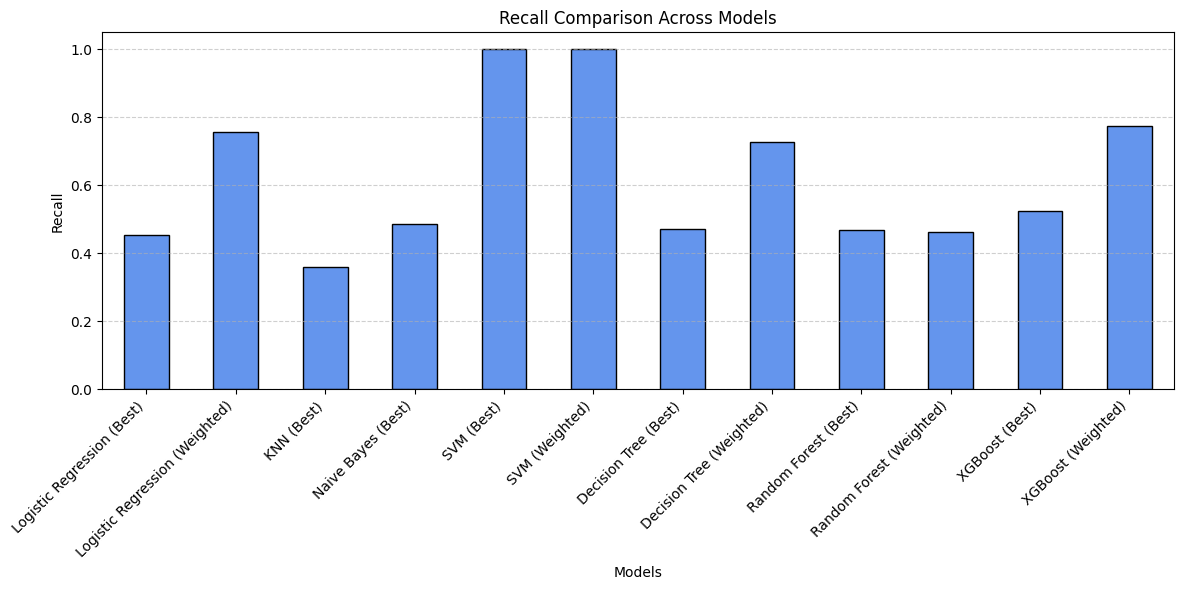

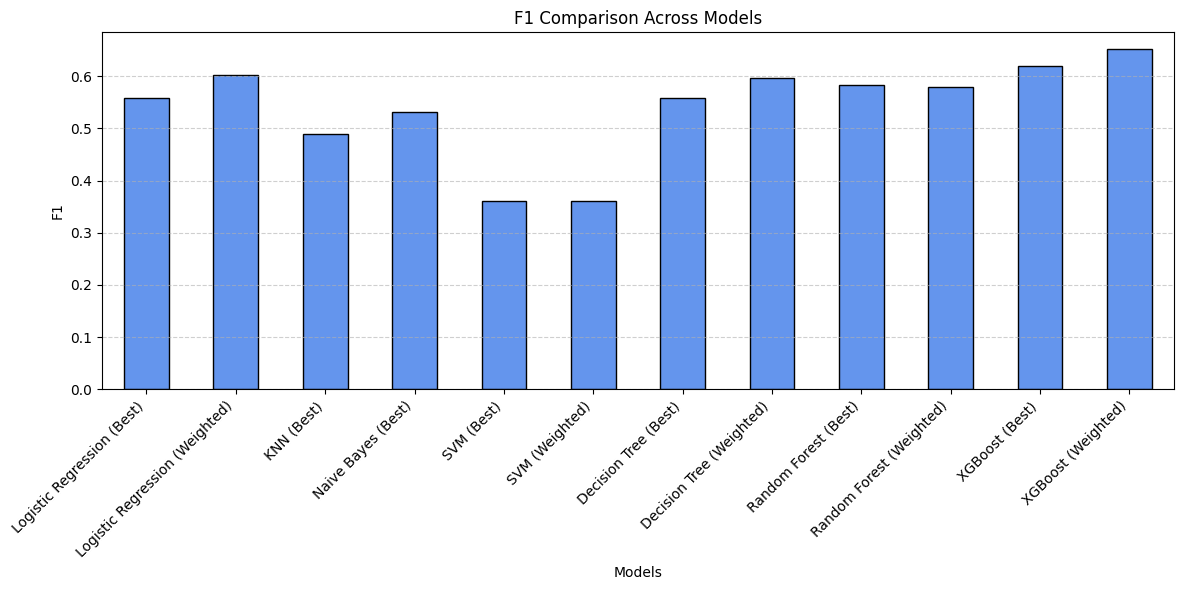

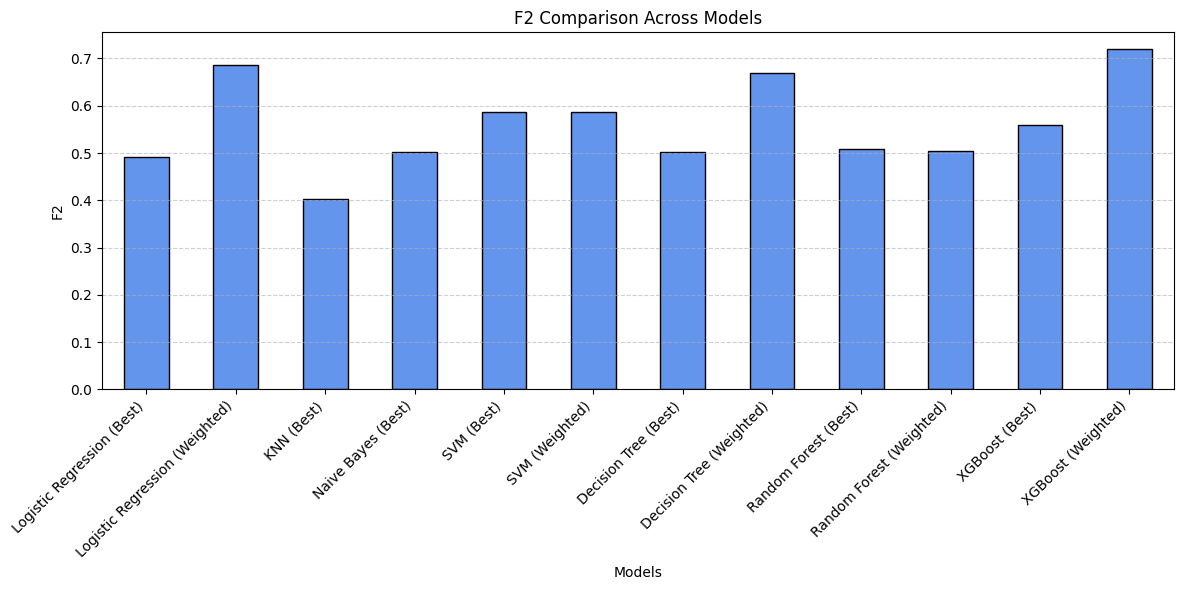

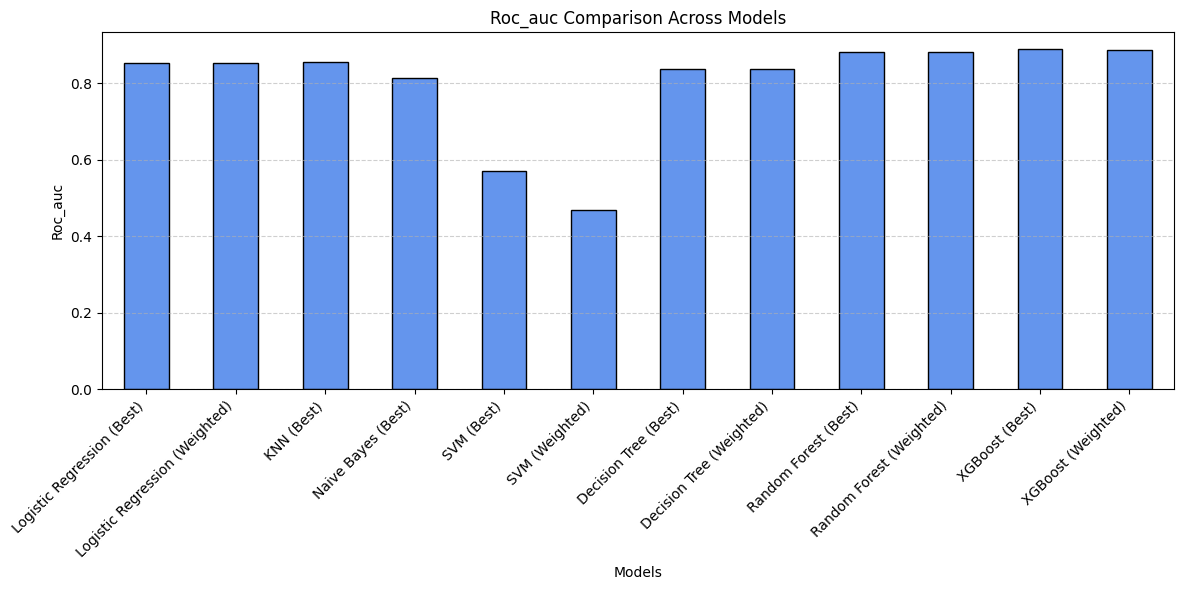

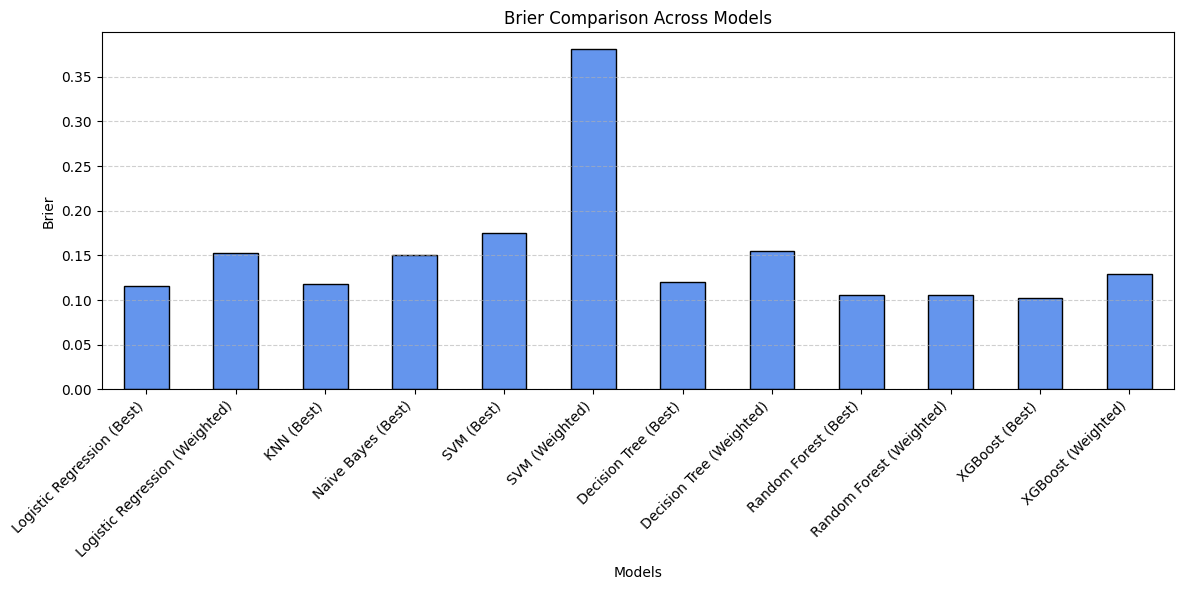

In [ ]:


lr_best_metrics = {'recall': 0.4547, 'f1': 0.5573, 'f2': 0.4908, 'roc_auc': 0.8522, 'brier': 0.1158}
lr_weighted_metrics = {'recall': 0.7558, 'f1': 0.6027, 'f2': 0.6861, 'roc_auc': 0.8529, 'brier': 0.1533}

knn_best_metrics = {'recall': 0.3598, 'f1': 0.4895, 'f2': 0.4025, 'roc_auc': 0.8557, 'brier': 0.1175}

nb_best_metrics = {'recall': 0.4852, 'f1': 0.5317, 'f2': 0.5028, 'roc_auc': 0.8149, 'brier': 0.1508}

svm_best_metrics = {'recall': 0.9998, 'f1': 0.3615, 'f2': 0.5859, 'roc_auc': 0.5711, 'brier': 0.1757}
svm_weighted_metrics = {'recall': 0.9998, 'f1': 0.3615, 'f2': 0.5859, 'roc_auc': 0.4681, 'brier': 0.3808}


model_performance = {
    "Logistic Regression (Best)": lr_best_metrics,
    "Logistic Regression (Weighted)": lr_weighted_metrics,
    "KNN (Best)": knn_best_metrics,
    "Naive Bayes (Best)": nb_best_metrics,
    "SVM (Best)": svm_best_metrics,
    "SVM (Weighted)": svm_weighted_metrics,
    "Decision Tree (Best)": dt_best_metrics,
    "Decision Tree (Weighted)": dt_weighted_metrics,
    "Random Forest (Best)": rf_best_metrics,
    "Random Forest (Weighted)": rf_weighted_metrics,
    "XGBoost (Best)": xgb_best_metrics,
    "XGBoost (Weighted)": xgb_weighted_metrics
}


df_metrics = pd.DataFrame(model_performance).T


print("========== Model Performance Comparison ==========")
print(df_metrics)


metrics_to_plot = ['recall', 'f1', 'f2', 'roc_auc', 'brier']


plt.figure(figsize=(12, 8))

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    df_metrics[metric].plot(kind='bar', color='cornflowerblue', edgecolor='black')
    plt.title(f'{metric.capitalize()} Comparison Across Models')
    plt.xlabel('Models')
    plt.ylabel(f'{metric.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


Logistic Regression Decision Tree and XGBoost showed improvements in recall with weighting.


 weighting is effective in improving recall for models sensitive to imbalance, but ensemble models like Random Forest and XGBoost remain robust even without weighting.

I tried to run the SHAP analysis, but it didn’t finish. I don’t know why; it didn’t reach a conclusion even after 2 hours, so I had to stop it.

In [ ]:


def shap_analysis(model, X, model_type="tree", top_n=10):



    if model_type.lower() == "tree":
        explainer = shap.TreeExplainer(model)

        shap_values = explainer.shap_values(X)



    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=top_n, show=False)
    plt.title("SHAP Summary (Bar) - Top Features")
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, max_display=top_n, show=False)
    plt.title("SHAP Summary (Beeswarm) - Top Features")
    plt.show()

    return shap_values


In [ ]:

shap_values = shap_analysis(rf_model, X_test, model_type="tree", top_n=10)
